In [7]:
%matplotlib notebook
%autosave 0
%load_ext autoreload
%autoreload 2
#%matplotlib inline
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import animation
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
import pickle
#from sklearn import svm, datasets
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix, classification_report, balanced_accuracy_score
from tqdm.notebook import tqdm

Autosave disabled
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
#sys.path.append("../imbalanced_dataset_sampler/torchsampler/")
sys.path.append("../libs")
from vvv_utils import parse_metadata, parse_light_curve_data, plot_light_curve, get_train_test_ids
#from imbalanced import ImbalancedDatasetSampler
from Modulin import LightCurve_Dataset, PartialConv, MLP_last
from training2 import *

**Cargar LCs**

In [3]:
df_meta = parse_metadata(experiment="ALL", merge_subclasses=True)

88454 light curve metadata collected


**Dataset**

In [ ]:
# CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_analisis.pkl', 'rb') as handle:
    VVV = pickle.load(handle)

In [4]:
# CARGAR dataset desde pickle
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_p1.pkl', 'rb') as handle:
    VVV_p1 = pickle.load(handle)
    
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_p2.pkl', 'rb') as handle:
    VVV_p2 = pickle.load(handle)
    
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_pO.pkl', 'rb') as handle:
    VVV_pO = pickle.load(handle)

In [18]:
%timeit -n1 -r1 LightCurve_Dataset(df_meta, 'P_ogle')

28min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
# tomó 32:32 min en armar el Dataset (Frank)

In [8]:
# GUARDAR Dataset with period Eenro 2021, para analisis de predicciones 
with open('/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/pickles/newDataset_VVV_analisis.pkl', 'wb') as handle:
    pickle.dump(VVV, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
cuda.is_available()

True

### Plotear Curvas de luz

In [34]:
VVV_pO[420]

{'data': tensor([[ 1.4731e-02, -7.0575e-01,  2.5976e-01,  1.1140e+03,  1.0000e+00],
         [ 2.1673e-02, -8.6304e-01,  3.6938e-01,  1.0689e+03,  1.0000e+00],
         [ 2.5769e-02, -1.3826e+00,  3.2648e-01,  1.5298e+03,  1.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]),
 'label': 0,
 'name': 'b274_207_54932',
 'period': 9.036078999999999,
 'amplitud': 0.04196215292114763}

In [36]:
VVV = [VVV_p1,VVV_p2,VVV_pO]
VVV_len = len(VVV[0])

In [41]:
def plot(dataset, idx, fig,ax):
    assert len(ax)==2, "Needs two subaxis"
    label = dataset[idx]["label"]
    ax[0].cla()
    ax[0].errorbar(dataset[idx]["data"][:, 0], dataset[idx]["data"][:, 1], dataset[idx]["data"][:, 2], fmt='.')
    ax[0].invert_yaxis()
    ax[1].cla()
    ax[1].errorbar(dataset[idx]["data"][:, 3], dataset[idx]["data"][:, 1], dataset[idx]["data"][:, 2], fmt='.')
    ax[1].invert_yaxis()
    #fig.title("%s"%(dataset[idx]["name"]))
    ax[0].set_title("k=%d  p=%0.4f" %(idx,dataset[idx]["period"]))
    ax[1].set_title("label= "+str(label))

In [49]:
def plot2(dataset, idx, fig,ax):
    #assert len(ax)==2, "Needs two subaxis"
    label = dataset[idx]["label"]
    ax[0].cla()
    ax[0].errorbar(dataset[idx]["data"][:, 0], dataset[idx]["data"][:, 1], dataset[idx]["data"][:, 2], fmt='.')
    ax[0].invert_yaxis()
    ax[1].cla()
    ax[1].errorbar(dataset[idx]["data"][:, 3], dataset[idx]["data"][:, 1], dataset[idx]["data"][:, 2], fmt='.')
    ax[1].invert_yaxis()
    #fig.title("%s"%(dataset[idx]["name"]))
    ax[0].set_title("k=%d  p=%0.4f" %(idx,dataset[idx]["period"]))
    ax[1].set_title("label= "+str(label))

In [14]:
def replot(dataset, i, fig,ax):
    label = dataset[i]["label"]
    dataset.plot(dataset,i, ax)
    ax[1].set_title("label= "+str(label))
    fig.show()

In [48]:
def get_LCs(dataset):
    binarias, rrlyrae, cefeidas = list(),list(),list()
    for lc in dataset:
        if lc['label']==0:
            binarias.append(lc)
        elif lc['label']==1:
            rrlyrae.append(lc)
        elif lc['label']==2:
            cefeidas.append(lc)
    #display(len(binarias),len(rrlyrae),len(cefeidas))
    LC = [binarias,rrlyrae,cefeidas]

    return LC

<IPython.core.display.Javascript object>


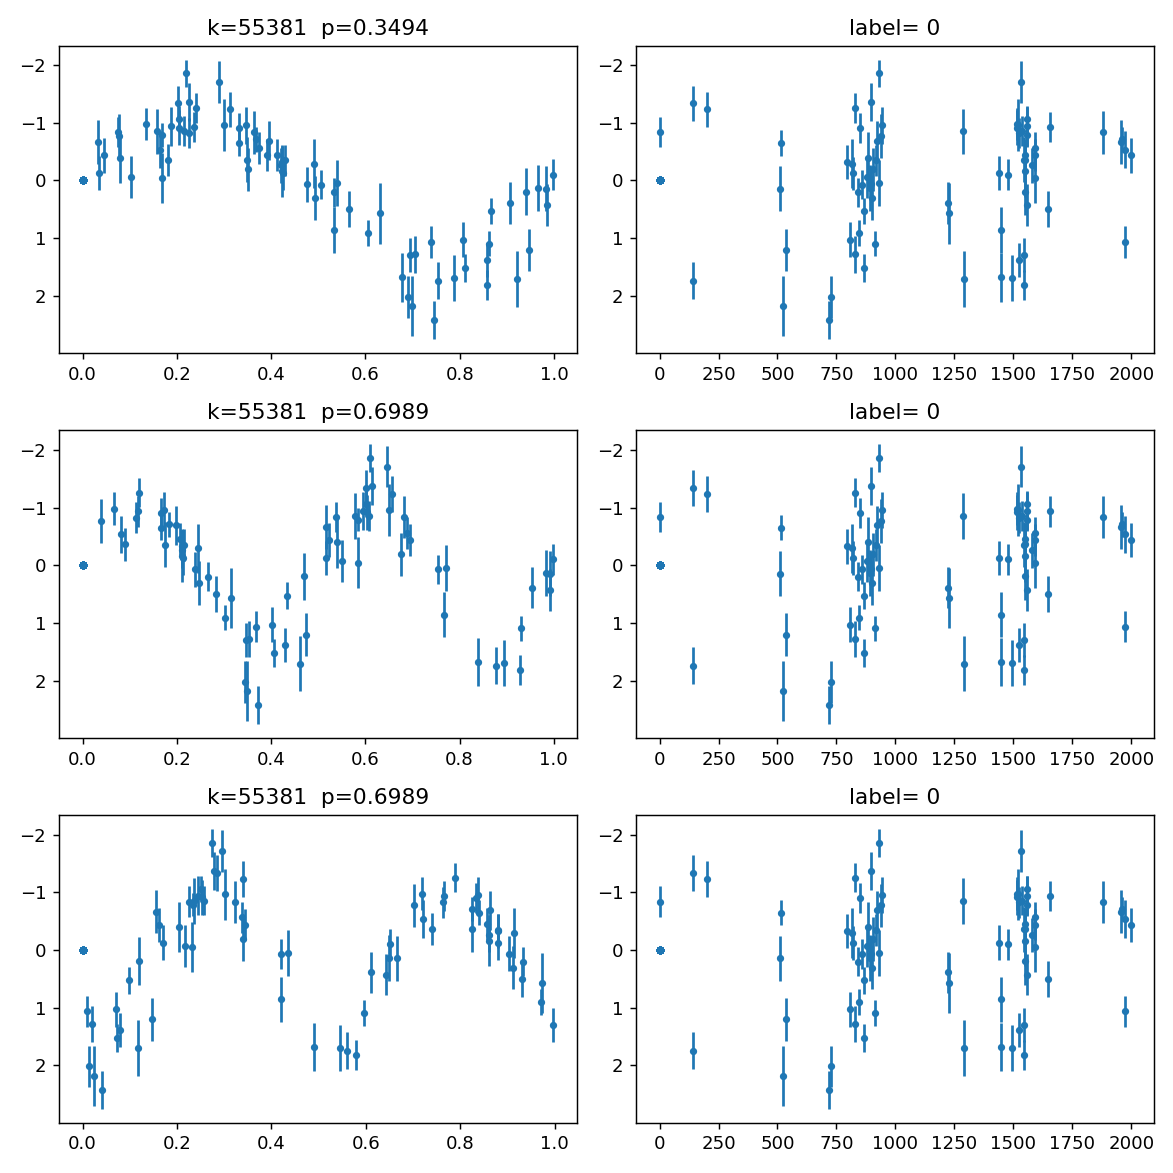

In [51]:
k_log = list()
#k = 0

k = np.random.randint(0,VVV_len)
k_log.append(k)
n_data = 3
fig, ax = plt.subplots(n_data,2, figsize=(9, 3*n_data), tight_layout=True)

for i,ax_ in enumerate(ax): 
    plot(VVV[i],k,fig,ax_)

b1 = widgets.Button(description="Prev")
b2 = widgets.Button(description="Next")
b3 = widgets.Button(description="Random")

display(widgets.HBox([b1, b2,b3]))

def on_button_clicked(b):
    global k
    if b.description == "Next":
        k +=1
    elif b.description == "Random":
        k = np.random.randint(0,VVV_len)
    else:
        if k>0:
            k-=1
    for i,ax_ in enumerate(ax): 
        plot(VVV[i],k,fig,ax_)

b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)
b3.on_click(on_button_clicked)

### Visualizar mapa CubeHelix

In [ ]:
fig,ax = plt.subplots(3,2,figsize=(8,12),tight_layout=True,sharey=True,sharex=True)
fig2,ax2 = plt.subplots(1,figsize=(3,3))
res=60

cm=plt.get_cmap('cubehelix')
#fig.suptitle('Densidad por tipo de clasificación', fontsize=12)



LC = get_LCs()



names = ['Binarias','RR Lyrae', 'Cefeidas']
#[ax_.cla() for ax_ in ax]
for i,stars in enumerate(LC):
    hTP=np.zeros(shape=(res,res))
    #hFP=np.zeros(shape=(res,res))
    hFN=np.zeros(shape=(res,res))
    for lc in stars:
        n=int(lc['data'][:, 4].sum().item())
        X=lc['data'][:n, 0].numpy()
        Y=lc['data'][:n, 1].numpy()
        yt=lc['label']
        yp=lc['pred']
        max_mag = np.argmax(mf(Y,5))

        X_roll = np.roll(X,-max_mag)
        Y_roll = np.roll(Y,-max_mag)

        h, xedge, yedge, _ = ax2.hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
        #print(hall)
        if yt==yp:
            hTP += h
        else:
            hFN += h
        #print(hFN.shape)
    ax[i][0].imshow(hTP.T,cmap=cm)
    #ax[i][0].axis('off')
    ax[i][0].set_ylabel(names[i],fontsize=16)
    ax[i][1].imshow(hFN.T,cmap=cm)
    #ax[i][1].axis('off')
    #ax[i][2].set_visible(False)
    
ax[0][0].set_title("TP",fontsize=16)
ax[0][1].set_title("FN",fontsize=16)
#ax[1].hist2d(X,Y_roll,bins=20)
#ax[0].invert_yaxis()
#ax[1].invert_yaxis()
#ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, rrl_t[idx]['label'],rrl_t[idx]['name']), fontsize=10)
#interact(update, idx=SelectionSlider(options=range(len(rrl_t))))

<IPython.core.display.Javascript object>


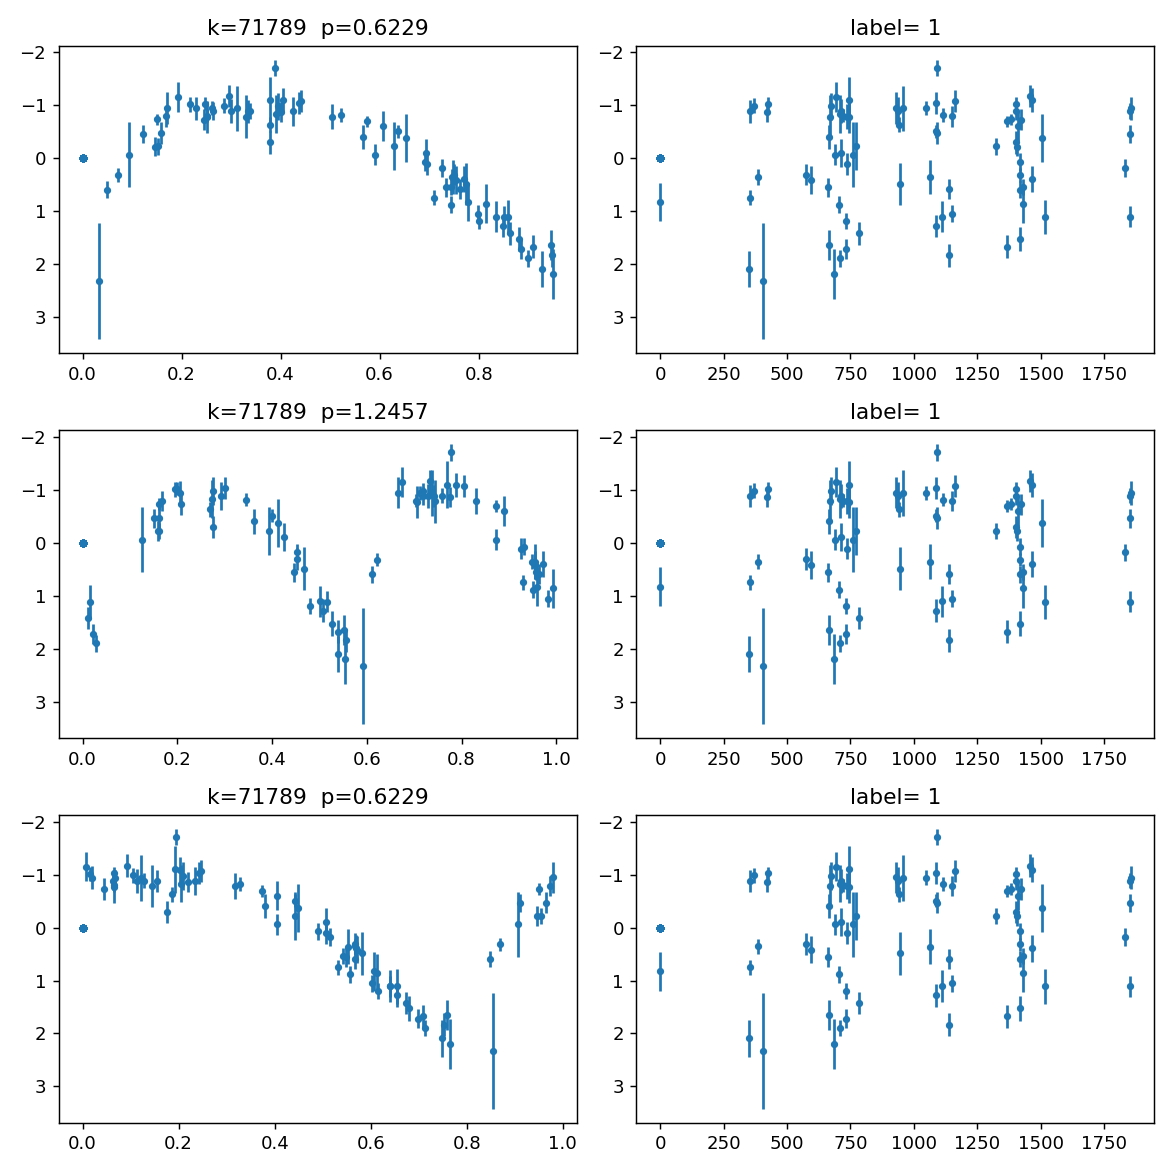

In [46]:
k_log = list()
#k = 0

k = np.random.randint(0,VVV_len)
k_log.append(k)
n_data = 3
fig, ax = plt.subplots(n_data,2, figsize=(9, 3*n_data), tight_layout=True)

for i,ax_ in enumerate(ax): 
    plot(VVV[i],k,fig,ax_)

b1 = widgets.Button(description="Prev")
b2 = widgets.Button(description="Next")
b3 = widgets.Button(description="Random")

display(widgets.HBox([b1, b2,b3]))

def on_button_clicked(b):
    global k
    if b.description == "Next":
        k +=1
    elif b.description == "Random":
        k = np.random.randint(0,VVV_len)
    else:
        if k>0:
            k-=1
    for i,ax_ in enumerate(ax): 
        plot(VVV[i],k,fig,ax_)

b1.on_click(on_button_clicked)
b2.on_click(on_button_clicked)
b3.on_click(on_button_clicked)

**Modelo**

In [8]:
def make_path(n,s):
    n_model = '0'+str(n)
    #path = '/home/amorales/tesis/LC_test/models/LCC_newDataset_model_'+n_model+'_'
    path = '/run/media/amorales/392cf315-7e84-4743-a143-b375a0604f7d/amorales/UACh/tesis/models/LCC_newDataset_model_'+n_model+'_'
    comentario = "sample_"+str(s)
    path_full = path+comentario+'.pt'
    return path_full

def load_besto_model(path_full,m_type):
    if m_type=='A':
        besto = MLP_last()
    elif m_type=='B':
        besto = MLP_lastB()
    elif m_type=='B3':
        besto = MLP_lastB3()
    besto.load_state_dict(torch.load(path_full,map_location='cuda:0')['model_state_dict'])
    return besto

def evaluate_model(besto,test_loader,m_type):
    prediction_test = []
    labels_test=[]
    if m_type=='A':
        for batch in test_loader:
            inputs, labels = batch['data'],batch['label']
            inputs = inputs.transpose(1,2)
            #display(inputs.shape,labels.shape)
            data,mask = inputs[:,[1,2]],inputs[:,4].unsqueeze(0).transpose(0,1)
            labels_test.append(labels.detach().numpy())
            #y_true=labels.cpu().numpy()
            #display(y_true)
            #break
            outputs = besto.forward(data,mask,t=0)
            # F1 score
            y_pred=outputs.detach().argmax(dim=1).numpy()
            #print(outputs)
            prediction_test.append(outputs.detach().argmax(dim=1).numpy())
            
    elif (m_type=='B') or (m_type=='B3'):
        if use_gpu:
            besto = besto.cuda()
        for batch in test_loader:
            inputs, labels = batch['data'],batch['label']
            inputs = inputs.transpose(1,2)
            #if use_gpu:
            #    inputs, labels = inputs.cuda(), labels.cuda()
            #display(inputs.shape,labels.shape)
            #model 3
            if m_type=='B3':
                data = inputs[:,1]
                data = data.unsqueeze(0).transpose(0,1)
            elif m_type=='B':
                #model 5
                data = inputs[:,[1,2]]
            #display(data.shape)
            #display(data.shape)
            data = data.type(torch.cuda.FloatTensor)
            labels_test.append(labels.detach().numpy())
            #y_true=labels.cpu().numpy()
            #display(y_true)
            #outputs = besto.forward(data,mask,t=0)
            outputs = besto.forward(data,t=0)
            # F1 score
            y_pred=outputs.detach().argmax(dim=1).cpu().numpy()
            #print(outputs)
            prediction_test.append(outputs.detach().argmax(dim=1).cpu().numpy())

    y_true = np.concatenate(labels_test)
    y_pred = np.concatenate(prediction_test)
    return y_true,y_pred


**Split dataset y Dataloaders**

Para un mayor analisis, es posible que deba evaluar/clasificar todas las curvas de luz, para luego en abse a esa prediccion hacer las agrupaciones

DataFrame donde las filas son las curvas de luz y las columnas son: fase, magnitud, error, cantidad de puntos, clase real, clase predicha, tipo de clasificacion (TP,FP o FN) y entropia.

In [9]:
train_valid_idx, test_idx = get_train_test_ids(df_meta,test_size=0.1)
# usar valid_idx sólo para validar, matriz de confusion final

# pasamos de tipo Int64Index a int32
#train_valid_idx, test_idx = np.array(train_valid_idx,dtype='int32'), np.array(test_idx, dtype='int32')

# slice por iloc del df_meta
df_train = df_meta.loc[train_valid_idx]
# sub dividir train_test_idx para train y test (un 20%)
train_idx, valid_idx = get_train_test_ids(df_train, test_size=0.2)

In [10]:
test_idx

Index(['b292_402_83438', 'b381_112_23559', 'b276_211_91437', 'b302_308_51394',
       'b375_616_45129', 'b262_308_53888', 'b259_616_35329', 'b292_213_30796',
       'DEK_32', 'b351_515_6740',
       ...
       'b297_306_24887', 'b298_302_24665', 'b311_306_72394', 'b366_211_33061',
       'b267_505_20705', 'b293_211_15629', 'b348_416_64838', 'b283_211_27467',
       'b362_106_54099', 'b387_602_1121'],
      dtype='object', name='ID_VVV', length=8846)

In [11]:
VVV_test = LightCurve_Dataset(df_meta.loc[test_idx])

In [13]:
len(VVV_test)

8848

In [13]:
test_loader = DataLoader(VVV_test, batch_size=512,shuffle=False)

In [32]:
binarias, rrlyrae, cefeidas = list(),list(),list()
for lc in VVV:
    if lc['label']==0:
        binarias.append(lc)
    elif lc['label']==1:
        rrlyrae.append(lc)
    elif lc['label']==2:
        cefeidas.append(lc)
display(len(binarias),len(rrlyrae),len(cefeidas))

67873

19087

1494

**Prediciones**

Agrupar por clase, por tipo de prediccion

In [13]:
bin_t, rrl_t, cef_t = list(),list(),list()
for lc in VVV_test:
    if lc['label']==0:
        bin_t.append(lc)
    elif lc['label']==1:
        rrl_t.append(lc)
    elif lc['label']==2:
        cef_t.append(lc)
display(len(bin_t),len(rrl_t),len(cef_t))

6790

1909

149

In [14]:
N_model,m_type,s='4','A',1
path_ = make_path(N_model,s)
besto = load_besto_model(path_,m_type)

In [15]:
for LC in [bin_t,rrl_t,cef_t]:
    for lc in LC:
        data,mask = lc['data'][:,[1,2]].unsqueeze(0).transpose(1,2),lc['data'][:,4].unsqueeze(0).unsqueeze(0)
        y_true=lc['label']
        #display(data.shape,mask.shape)
        outputs = besto.forward(data,mask,t=0)
        y_pred=outputs.detach().argmax(dim=1).item()
        #display(y_true,y_pred)
        #prediction_test.append(y_pred)
        lc['pred']=y_pred
        #break

Entropia de predicciones

In [16]:
for LC in [bin_t,rrl_t,cef_t]:
    for lc in LC:
        data,mask = lc['data'][:,[1,2]].unsqueeze(0).transpose(1,2),lc['data'][:,4].unsqueeze(0).unsqueeze(0)
        #y_true=lc['label']
        #display(data.shape,mask.shape)
        outputs = besto.forward(data,mask,t=0)
        p = torch.nn.Softmax(dim=1)(outputs.detach())
        entropy = -torch.sum(p*torch.log(p+1e-10),dim=1).item()
        #y_pred=outputs.detach().argmax(dim=1).item()
        #display(p,entropy)
        #prediction_test.append(y_pred)
        lc['entropy']=entropy
        #break

Signal to Noise ratio

In [17]:
for LC in [bin_t,rrl_t,cef_t]:
    for lc in LC:
        n=int(lc['data'][:, 4].sum().item())
        err=lc['data'][:n, 2]
        mag=lc['data'][:n, 1]
        SNR = torch.var(mag)/torch.median(err**2)
        lc['SNR']=SNR.item()

Cantidad de puntos

In [18]:
for LC in [bin_t,rrl_t,cef_t]:
    for lc in LC:
        n=int(lc['data'][:, 4].sum().item())
        lc['n']=n

In [19]:
rrl_t[42]

{'data': tensor([[ 2.0940e-02, -8.0171e-01,  2.8207e-01,  1.1310e+03,  1.0000e+00],
         [ 2.3173e-02, -1.3448e+00,  2.9785e-01,  7.5006e+02,  1.0000e+00],
         [ 3.8566e-02, -5.4280e-01,  2.9891e-01,  6.6322e+02,  1.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]),
 'label': 1,
 'name': 'b301_104_32147',
 'pred': 1,
 'entropy': 0.083552286028862,
 'SNR': 11.514735221862793,
 'n': 83}

### Visualizacion

In [20]:
from ipywidgets import interact, Button, Output, Box, IntSlider, SelectionSlider

In [21]:
ent_bin_TP = [lc['entropy'] for lc in bin_t if lc['pred']==0]
ent_bin_rrl = [lc['entropy'] for lc in bin_t if lc['pred']==1]
ent_bin_cef = [lc['entropy'] for lc in bin_t if lc['pred']==2]
entr_bin = [ent_bin_TP,ent_bin_rrl,ent_bin_cef]

ent_rrl_TP = [lc['entropy'] for lc in rrl_t if lc['pred']==1]
ent_rrl_bin = [lc['entropy'] for lc in rrl_t if lc['pred']==0]
ent_rrl_cef = [lc['entropy'] for lc in rrl_t if lc['pred']==2]
entr_rrl = [ent_rrl_bin,ent_rrl_TP,ent_rrl_cef]

ent_cef_TP = [lc['entropy'] for lc in cef_t if lc['pred']==2]
ent_cef_bin = [lc['entropy'] for lc in cef_t if lc['pred']==0]
ent_cef_rrl = [lc['entropy'] for lc in cef_t if lc['pred']==1]
entr_cef = [ent_cef_bin,ent_cef_rrl,ent_cef_TP]

<IPython.core.display.Javascript object>


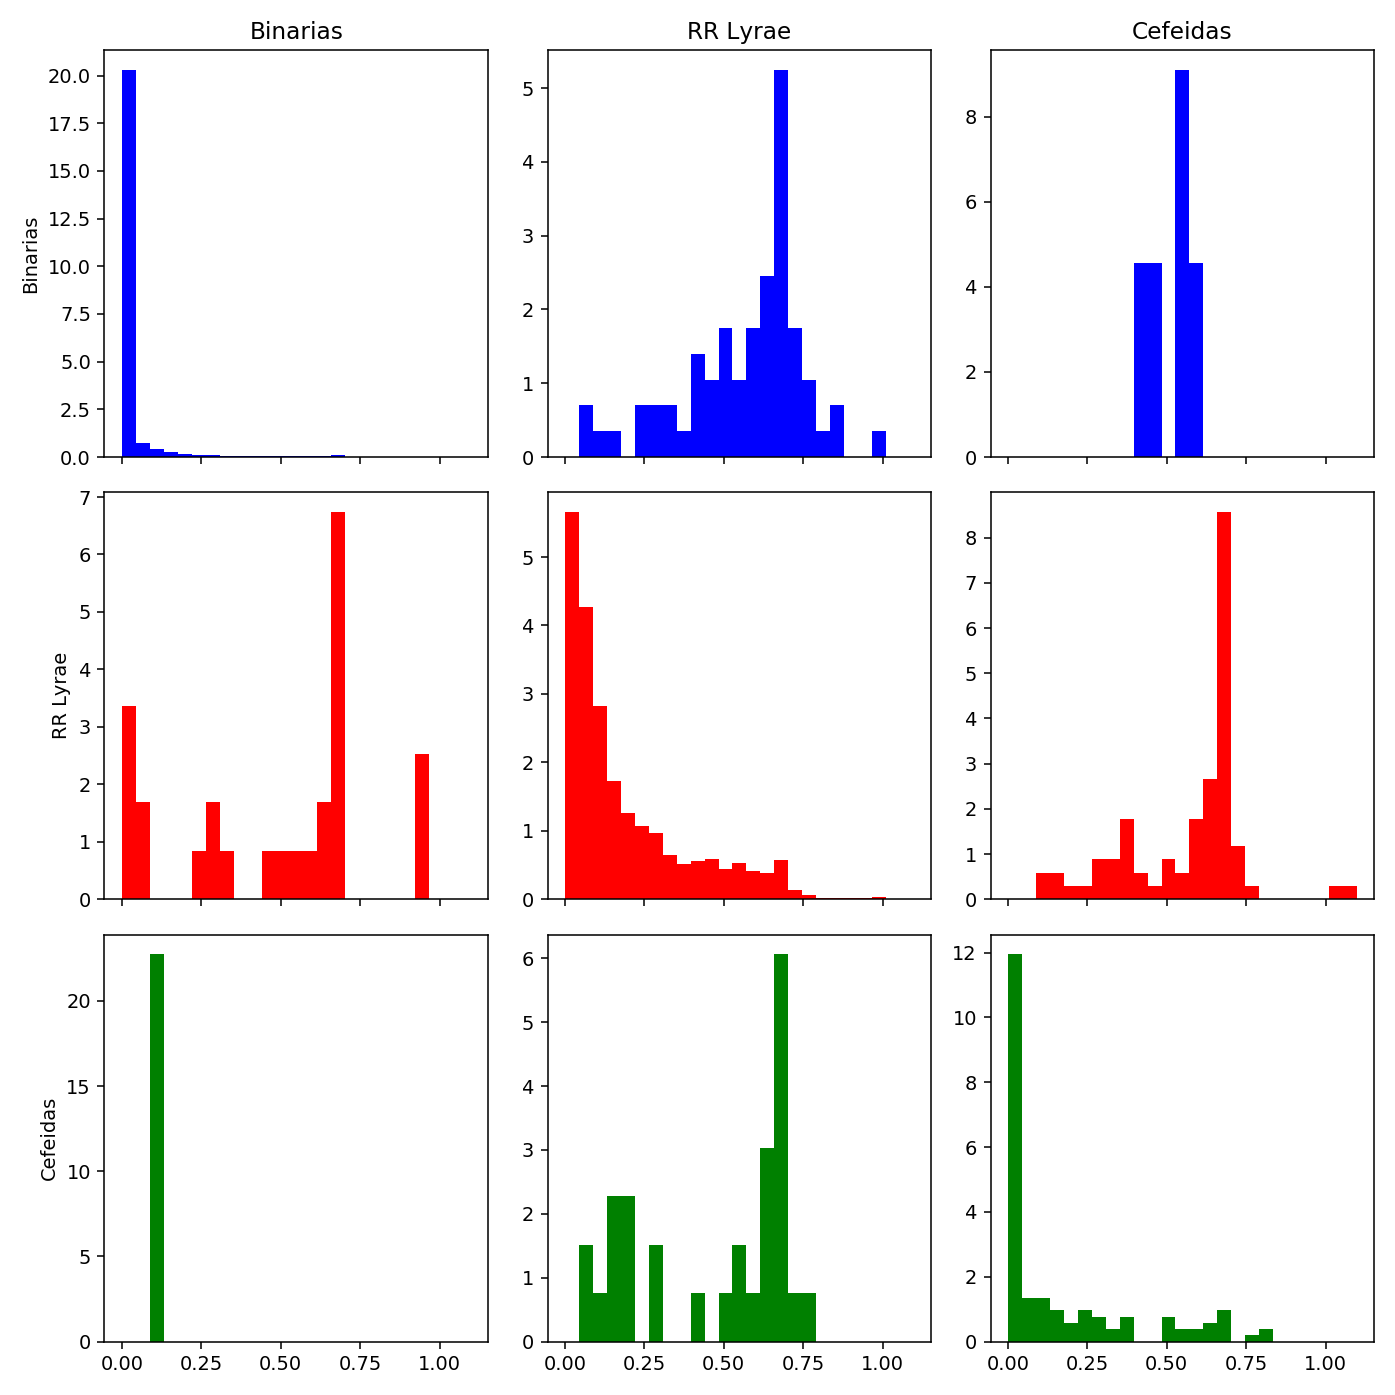

Text(0.5, 1.0, 'Cefeidas')

In [23]:
fig,ax = plt.subplots(3,3,figsize=(10,10),tight_layout=True,sharey=False,sharex=True)
#fig.suptitle('Entropia predicciones', fontsize=12)

for i in [0,1,2]:
    ax[0][i].hist(entr_bin[i],bins=25,range=(0,np.log(3)),density=True,color='blue')
    ax[1][i].hist(entr_rrl[i],bins=25,range=(0,np.log(3)),density=True,color='red')
    ax[2][i].hist(entr_cef[i],bins=25,range=(0,np.log(3)),density=True,color='green')

#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')

ax[0][0].set_title('Binarias')
ax[0][1].set_title('RR Lyrae')
ax[0][2].set_title('Cefeidas')

> la entropia de los tres casos en general está concentrada hacia el cero, lo que muestra una confianza en la decisiond el modelo. Donde las ECL tienen amyor confianza/menor entropia. Moda cercana a ceo pero distinta para las clases

> en los casos erroneos, la mdoa de la entropia está entre $0.5$ y $0.6$, lo cual no es malo 

> la entropia entre $[0, 1.09]$

> verificar errores con entropia baja, ya que puede deberse a etiqeuta mal peusta

In [24]:
n_bin_TP = [lc['n'] for lc in bin_t if lc['pred']==0]
n_bin_rrl = [lc['n'] for lc in bin_t if lc['pred']==1]
n_bin_cef = [lc['n'] for lc in bin_t if lc['pred']==2]
N_bin = [n_bin_TP,n_bin_rrl,n_bin_cef]

n_rrl_TP = [lc['n'] for lc in rrl_t if lc['pred']==1]
n_rrl_bin = [lc['n'] for lc in rrl_t if lc['pred']==0]
n_rrl_cef = [lc['n'] for lc in rrl_t if lc['pred']==2]
N_rrl = [n_rrl_bin,n_rrl_TP,n_rrl_cef]

n_cef_TP = [lc['n'] for lc in cef_t if lc['pred']==2]
n_cef_bin = [lc['n'] for lc in cef_t if lc['pred']==0]
n_cef_rrl = [lc['n'] for lc in cef_t if lc['pred']==1]
N_cef = [n_cef_bin,n_cef_rrl,n_cef_TP]

<IPython.core.display.Javascript object>


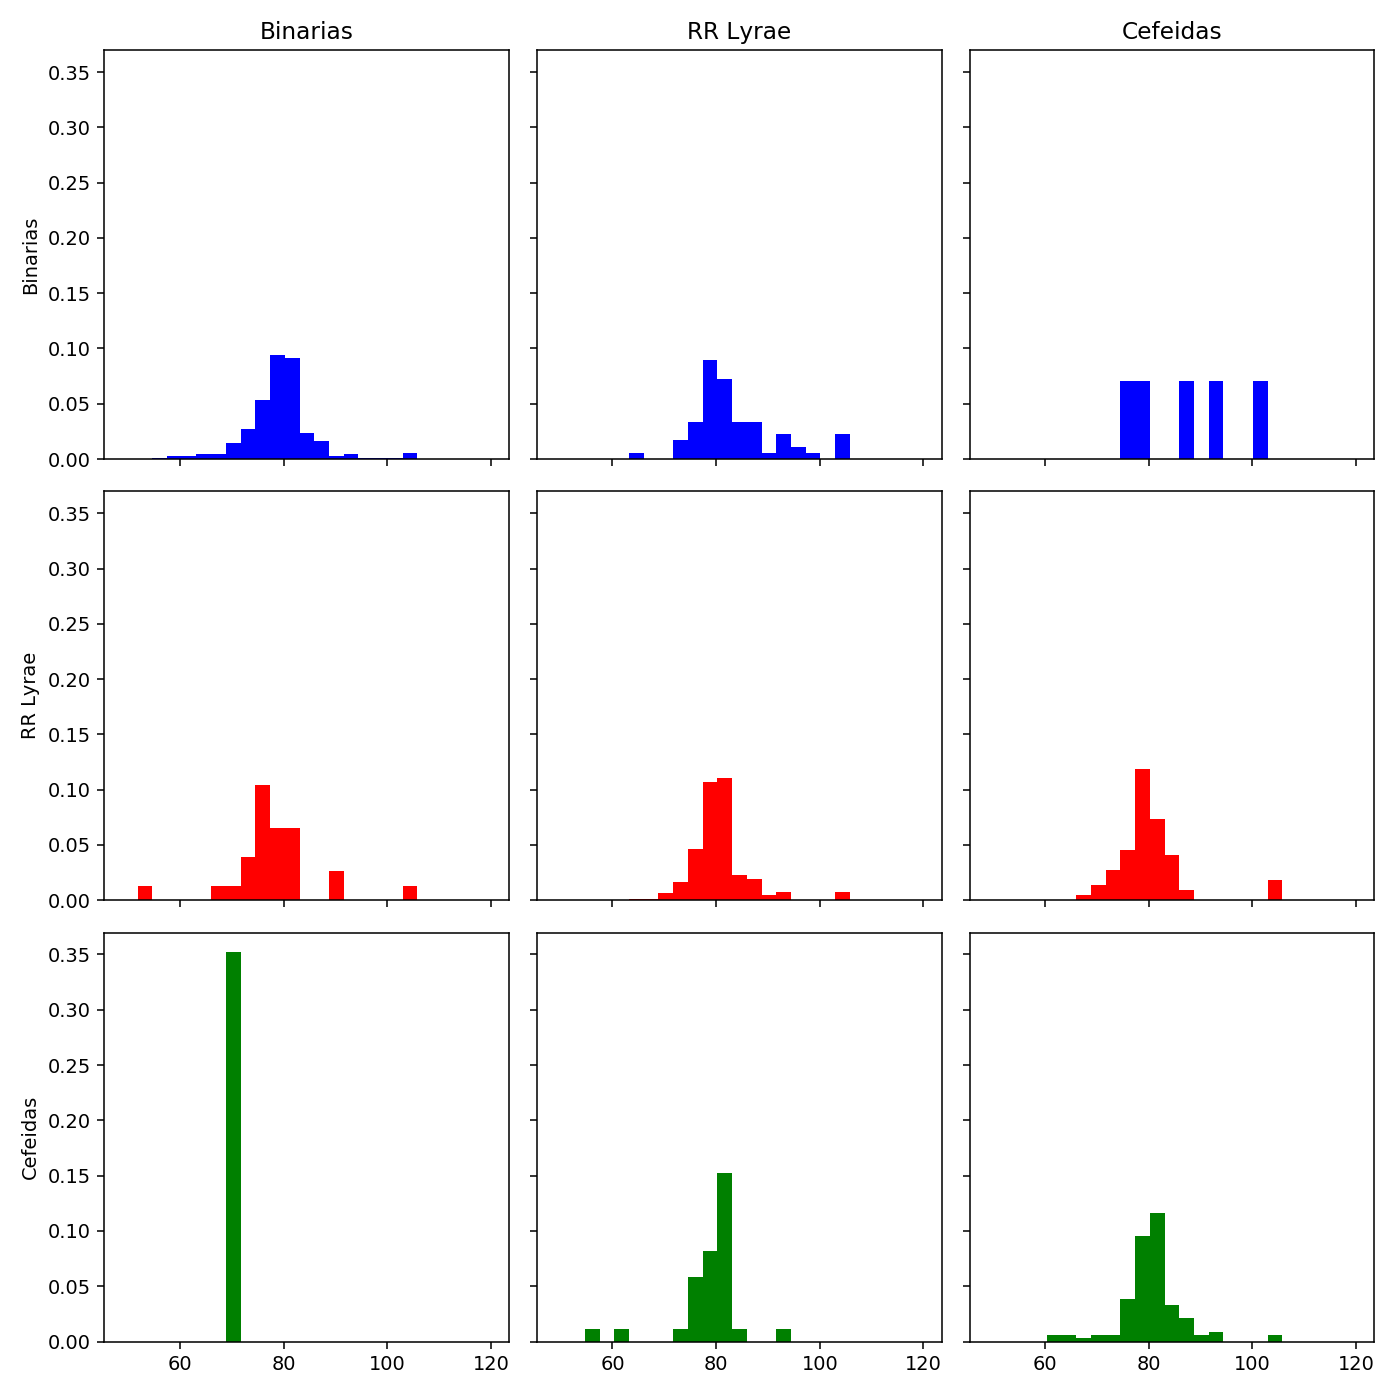

Text(0.5, 1.0, 'Cefeidas')

In [27]:
fig,ax = plt.subplots(3,3,figsize=(10,10),tight_layout=True,sharey=True,sharex=True)
#fig.suptitle('Distribucion N puntos', fontsize=12)

for i in [0,1,2]:
    ax[0][i].hist(N_bin[i],bins=25,range=(49,120),density=True,color='blue')
    ax[1][i].hist(N_rrl[i],bins=25,range=(49,120),density=True,color='red')
    ax[2][i].hist(N_cef[i],bins=25,range=(49,120),density=True,color='green')
#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')
ax[0][0].set_title('Binarias')
ax[0][1].set_title('RR Lyrae')
ax[0][2].set_title('Cefeidas')

> El largo de la curva (cantidad de obs) no parece estar significativamente correlacioado con la clasificacion

In [28]:
snr_bin_TP = [lc['SNR'] for lc in bin_t if lc['pred']==0]
snr_bin_rrl = [lc['SNR'] for lc in bin_t if lc['pred']==1]
snr_bin_cef = [lc['SNR'] for lc in bin_t if lc['pred']==2]
SNR_bin = [snr_bin_TP,snr_bin_rrl,snr_bin_cef]

snr_rrl_TP = [lc['SNR'] for lc in rrl_t if lc['pred']==1]
snr_rrl_bin = [lc['SNR'] for lc in rrl_t if lc['pred']==0]
snr_rrl_cef = [lc['SNR'] for lc in rrl_t if lc['pred']==2]
SNR_rrl = [snr_rrl_bin,snr_rrl_TP,snr_rrl_cef]

snr_cef_TP = [lc['SNR'] for lc in cef_t if lc['pred']==2]
snr_cef_bin = [lc['SNR'] for lc in cef_t if lc['pred']==0]
snr_cef_rrl = [lc['SNR'] for lc in cef_t if lc['pred']==1]
SNR_cef = [snr_cef_bin,snr_cef_rrl,snr_cef_TP]

<IPython.core.display.Javascript object>


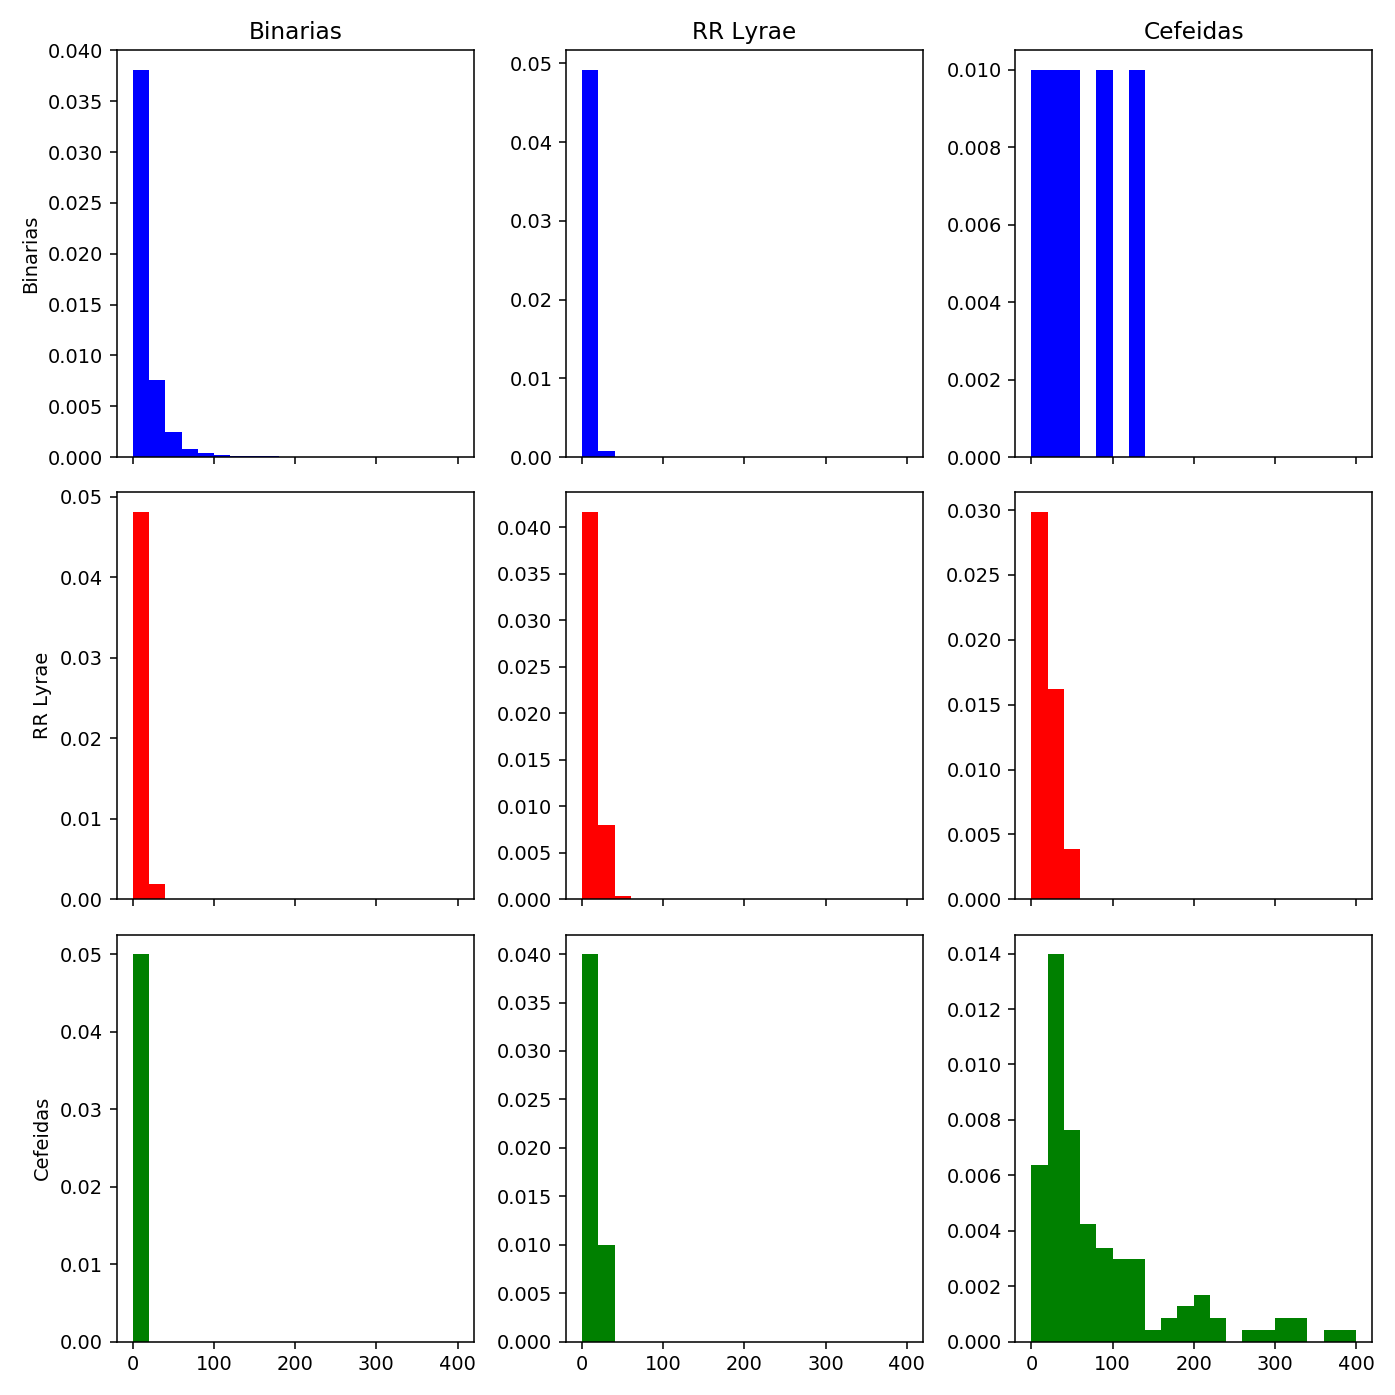

Text(0.5, 1.0, 'Cefeidas')

In [29]:
fig,ax = plt.subplots(3,3,figsize=(10,10),tight_layout=True,sharey=False,sharex=True)
#fig.suptitle('SNR', fontsize=12)

for i in [0,1,2]:
    ax[0][i].hist(SNR_bin[i],bins=20,range=(0,400),density=True,color='blue')
    ax[1][i].hist(SNR_rrl[i],bins=20,range=(0,400),density=True,color='red')
    ax[2][i].hist(SNR_cef[i],bins=20,range=(0,400),density=True,color='green')
    
#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')
ax[0][0].set_title('Binarias')
ax[0][1].set_title('RR Lyrae')
ax[0][2].set_title('Cefeidas')

### Tests Estadísticos

Se agrupan FP+FN para facilitar aplciacion de tests a dos poblaciones

In [86]:
from scipy.stats import mannwhitneyu as MWU
from scipy.stats import skewtest
from scipy.stats import kurtosistest

**MWU**

La hipótesis nula $H_0$ es que no hay diferencia entre las distribuciones muestrales.

El valor $\alpha$ es de $5\%$ con lo que la prueba tiene un $95\%$ de confianza.

In [87]:
ENTROPY = [entr_bin,entr_rrl,entr_cef]
SIGNALNOISE = [SNR_bin,SNR_rrl,SNR_cef]
N_POINTS = [N_bin,N_rrl,N_cef]

nombres = ['Binarias','RR Lyrae','Cefeidas']
# CLASE |  TP  | FP+FN
# ECL   | 6720 | 70
# RRL   | 1805 | 104
# CEF   | 118  | 31
nom_metr = ['Entropia','SNR','N']

for k,metrica in enumerate([ENTROPY,SIGNALNOISE,N_POINTS]):
    print(nom_metr[k])
    print("Clase & $Sk_{TP}$ & $Sk_{FN}$ & $Ku_{TP}$ & $Ku_{FN}$ & pV MWU \\")
    print("\hline")
    for i,stars in enumerate(metrica):
        if i==0:
            ET = stars[0]
            EF = stars[1]+stars[2]
        elif i==1:
            ET = stars[1]
            EF = stars[0]+stars[2]
        elif i==2:
            ET = stars[2]
            EF = stars[0]+stars[1]
        #print(len(ET),len(EF))
        sk_ET, pVsk_ET = skewtest(ET)
        sk_EF, pVsk_EF = skewtest(EF)
        ku_ET, pVku_ET = kurtosistest(ET)
        ku_EF, pVku_EF = kurtosistest(EF)
        st_MWU, pV_MWU = MWU(ET,EF)
        """
        print("Simetría y Kurtosis, muestra TP, clase %s es: %.3f y %.3f,con un P value de %.3f y %.3f resp." % (nombres[i],sk_ET,ku_ET,pVsk_ET,pVku_ET))
        print("Simetría y Kurtosis, muestra FP+FN, clase %s es: %.3f y %.3f,con un P value de %.3f y %.3f resp." % (nombres[i],sk_EF,ku_EF,pVsk_EF,pVku_EF))

        print("\nPara la clase ",nombres[i],":",end="")
        if pV_MWU < 0.05:
            display("Rechazo la hipótesis nula, por tanto existen diferencias entre las distribuciones muestrales.")
        else:
            print("No se peude rechazar la hipótesis nula.\n")
        
        
        
        """

        if i==0:
            print("ECL & %.4f & %.4f & %.4f & %.4f & %.4f \\" % (pVsk_ET,pVsk_EF,pVku_ET,pVku_EF,pV_MWU))
        elif i==1:
            print("RRL %.4f & %.4f & %.4f & %.4f & %.4f \\" % (pVsk_ET,pVsk_EF,pVku_ET,pVku_EF,pV_MWU))
        elif i==2:
            print("CEF & %.4f & %.4f & %.4f & %.4f & %.4f \\" % (pVsk_ET,pVsk_EF,pVku_ET,pVku_EF,pV_MWU))
    print("---------------------------------------------------\n")

Entropia
Clase & $Sk_{TP}$ & $Sk_{FN}$ & $Ku_{TP}$ & $Ku_{FN}$ & pV MWU \
\hline
ECL & 0.0000 & 0.0135 & 0.0000 & 0.3200 & 0.0000 \
RRL 0.0000 & 0.0064 & 0.0000 & 0.4874 & 0.0000 \
CEF & 0.0000 & 0.3231 & 0.1705 & 0.0000 & 0.0000 \
---------------------------------------------------

SNR
Clase & $Sk_{TP}$ & $Sk_{FN}$ & $Ku_{TP}$ & $Ku_{FN}$ & pV MWU \
\hline
ECL & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0016 \
RRL 0.0000 & 0.0000 & 0.0000 & 0.0266 & 0.0339 \
CEF & 0.0000 & 0.3194 & 0.0008 & 0.5512 & 0.0000 \
---------------------------------------------------

N
Clase & $Sk_{TP}$ & $Sk_{FN}$ & $Ku_{TP}$ & $Ku_{FN}$ & pV MWU \
\hline
ECL & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \
RRL 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0093 \
CEF & 0.1245 & 0.0017 & 0.0000 & 0.0035 & 0.0515 \
---------------------------------------------------



<IPython.core.display.Javascript object>


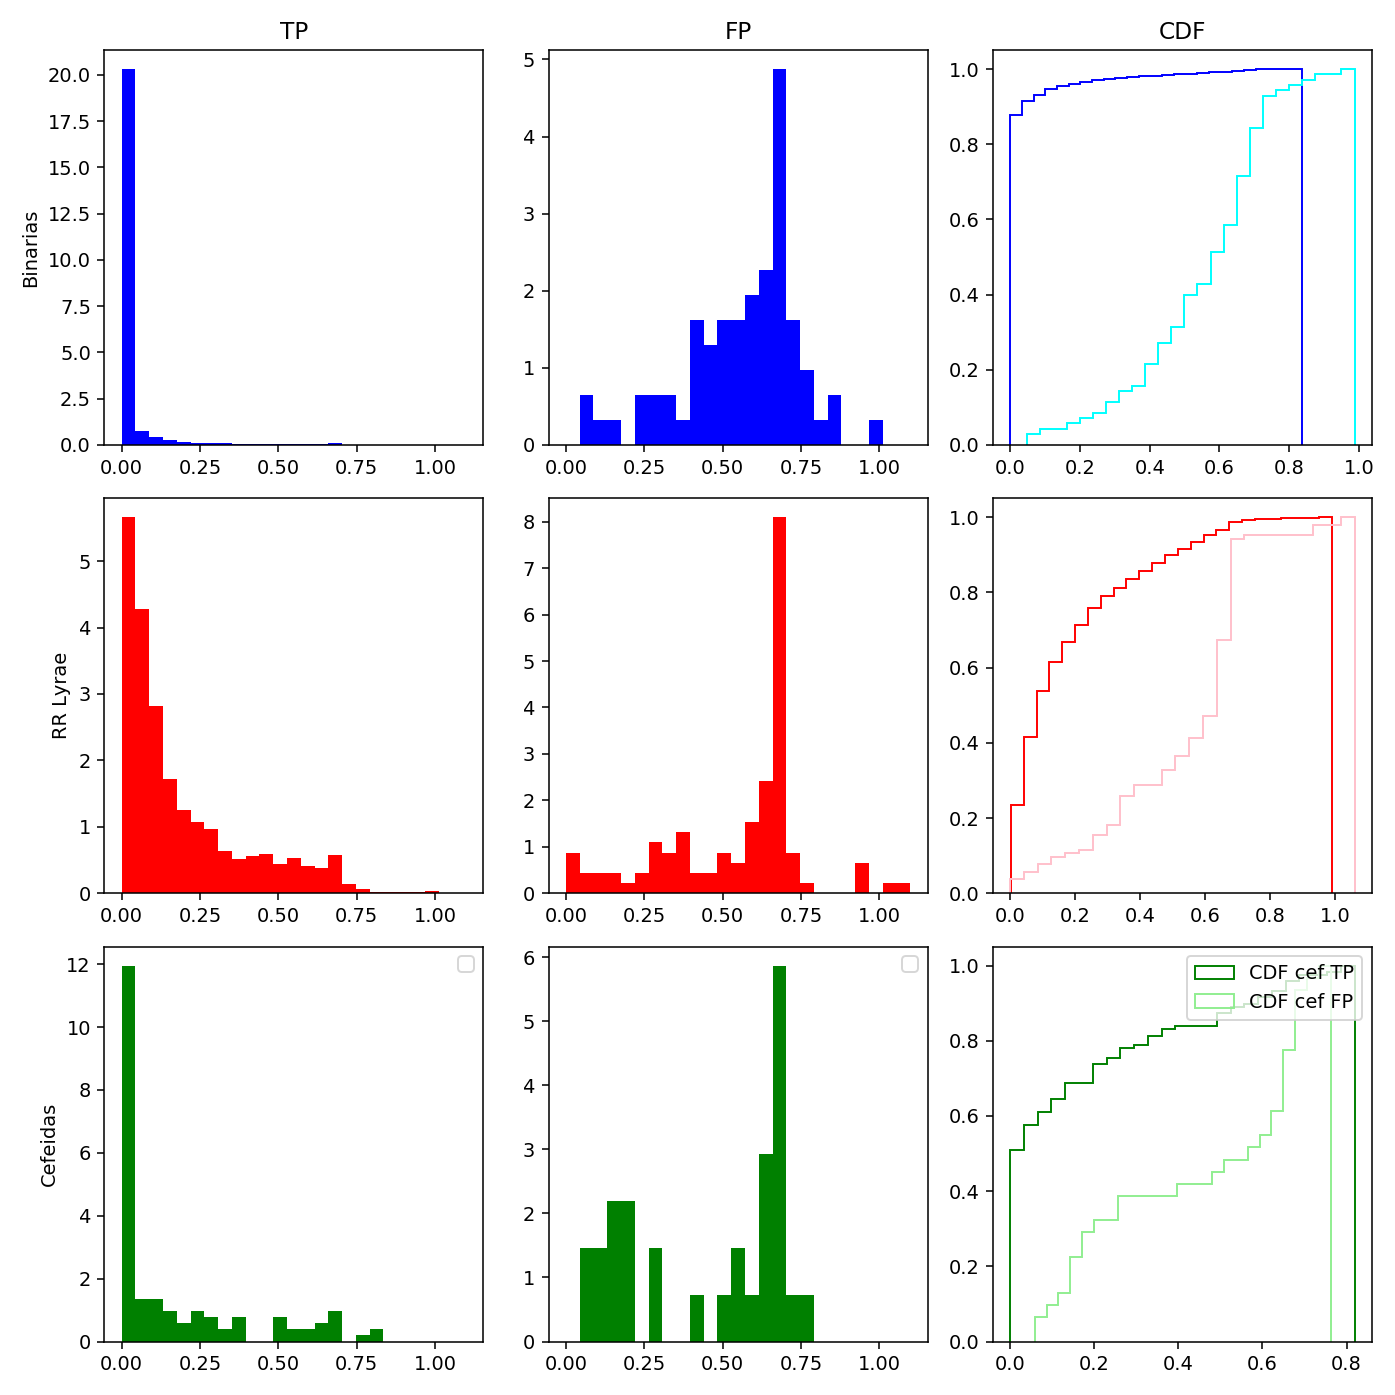

/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/

In [80]:
fig,ax = plt.subplots(3,3,figsize=(10,10),tight_layout=True,sharey=False,sharex=False)
#fig.suptitle('SNR', fontsize=12)

bins=25
ax[0][0].hist(entr_bin[0],bins=bins,range=(0,np.log(3)),density=True,color='blue')
ax[1][0].hist(entr_rrl[1],bins=bins,range=(0,np.log(3)),density=True,color='red')
ax[2][0].hist(entr_cef[2],bins=bins,range=(0,np.log(3)),density=True,color='green')
ax[0][1].hist(entr_bin[1]+entr_bin[2],bins=bins,range=(0,np.log(3)),density=True,color='blue')
ax[1][1].hist(entr_rrl[0]+entr_rrl[2],bins=bins,range=(0,np.log(3)),density=True,color='red')
ax[2][1].hist(entr_cef[0]+entr_cef[1],bins=bins,range=(0,np.log(3)),density=True,color='green')
ax[0][2].hist(entr_bin[0], bins, normed=1, histtype='step', cumulative=True, label='CDF bin TP',color='blue')
ax[1][2].hist(entr_rrl[1], bins, normed=1, histtype='step', cumulative=True, label='CDF rrl TP',color='red')
ax[2][2].hist(entr_cef[2], bins, normed=1, histtype='step', cumulative=True, label='CDF cef TP',color='green')
ax[0][2].hist(entr_bin[1]+entr_bin[2], bins, normed=1, histtype='step', cumulative=True, label='CDF bin FP',color='cyan')
ax[1][2].hist(entr_rrl[0]+entr_rrl[2], bins, normed=1, histtype='step', cumulative=True, label='CDF rrl FP',color='pink')
ax[2][2].hist(entr_cef[0]+entr_cef[1], bins, normed=1, histtype='step', cumulative=True, label='CDF cef FP',color='lightgreen')


#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')
ax[0][0].set_title('TP')
ax[0][1].set_title('FP')
ax[0][2].set_title('CDF')
#ax[0][2].set_title('Cefeidas')
[ax_.legend() for ax_ in ax[:][2]]

<IPython.core.display.Javascript object>


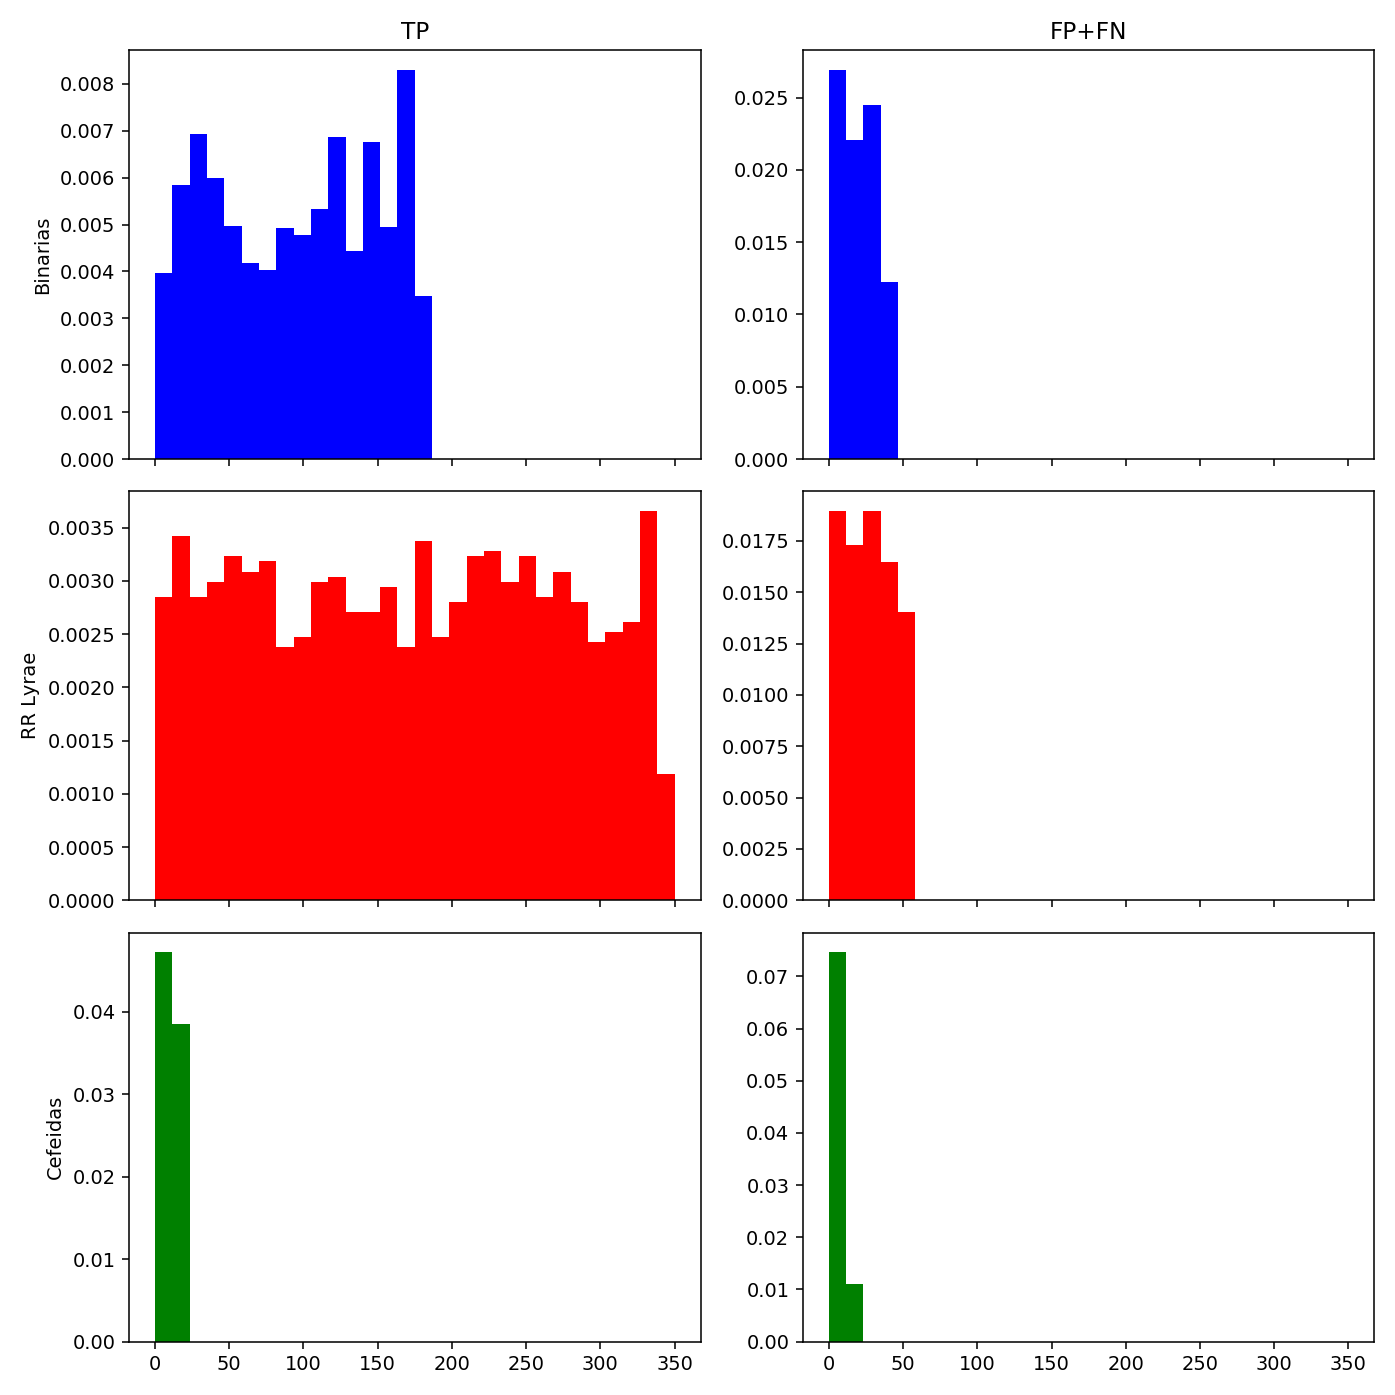

Text(0.5, 1.0, 'FP+FN')

In [49]:
fig,ax = plt.subplots(3,2,figsize=(10,10),tight_layout=True,sharey=False,sharex=True)
#fig.suptitle('SNR', fontsize=12)


ax[0][0].hist(np.cumsum(entr_bin[0]),bins=30,range=(0,350),density=True,color='blue')
ax[1][0].hist(np.cumsum(entr_rrl[1]),bins=30,range=(0,350),density=True,color='red')
ax[2][0].hist(np.cumsum(entr_cef[2]),bins=30,range=(0,350),density=True,color='green')
ax[0][1].hist(np.cumsum(entr_bin[1]+entr_bin[2]),bins=30,range=(0,350),density=True,color='blue')
ax[1][1].hist(np.cumsum(entr_rrl[0]+entr_rrl[2]),bins=30,range=(0,350),density=True,color='red')
ax[2][1].hist(np.cumsum(entr_cef[0]+entr_cef[1]),bins=30,range=(0,350),density=True,color='green')

#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')
ax[0][0].set_title('TP')
ax[0][1].set_title('FP+FN')
#ax[0][2].set_title('Cefeidas')

<IPython.core.display.Javascript object>


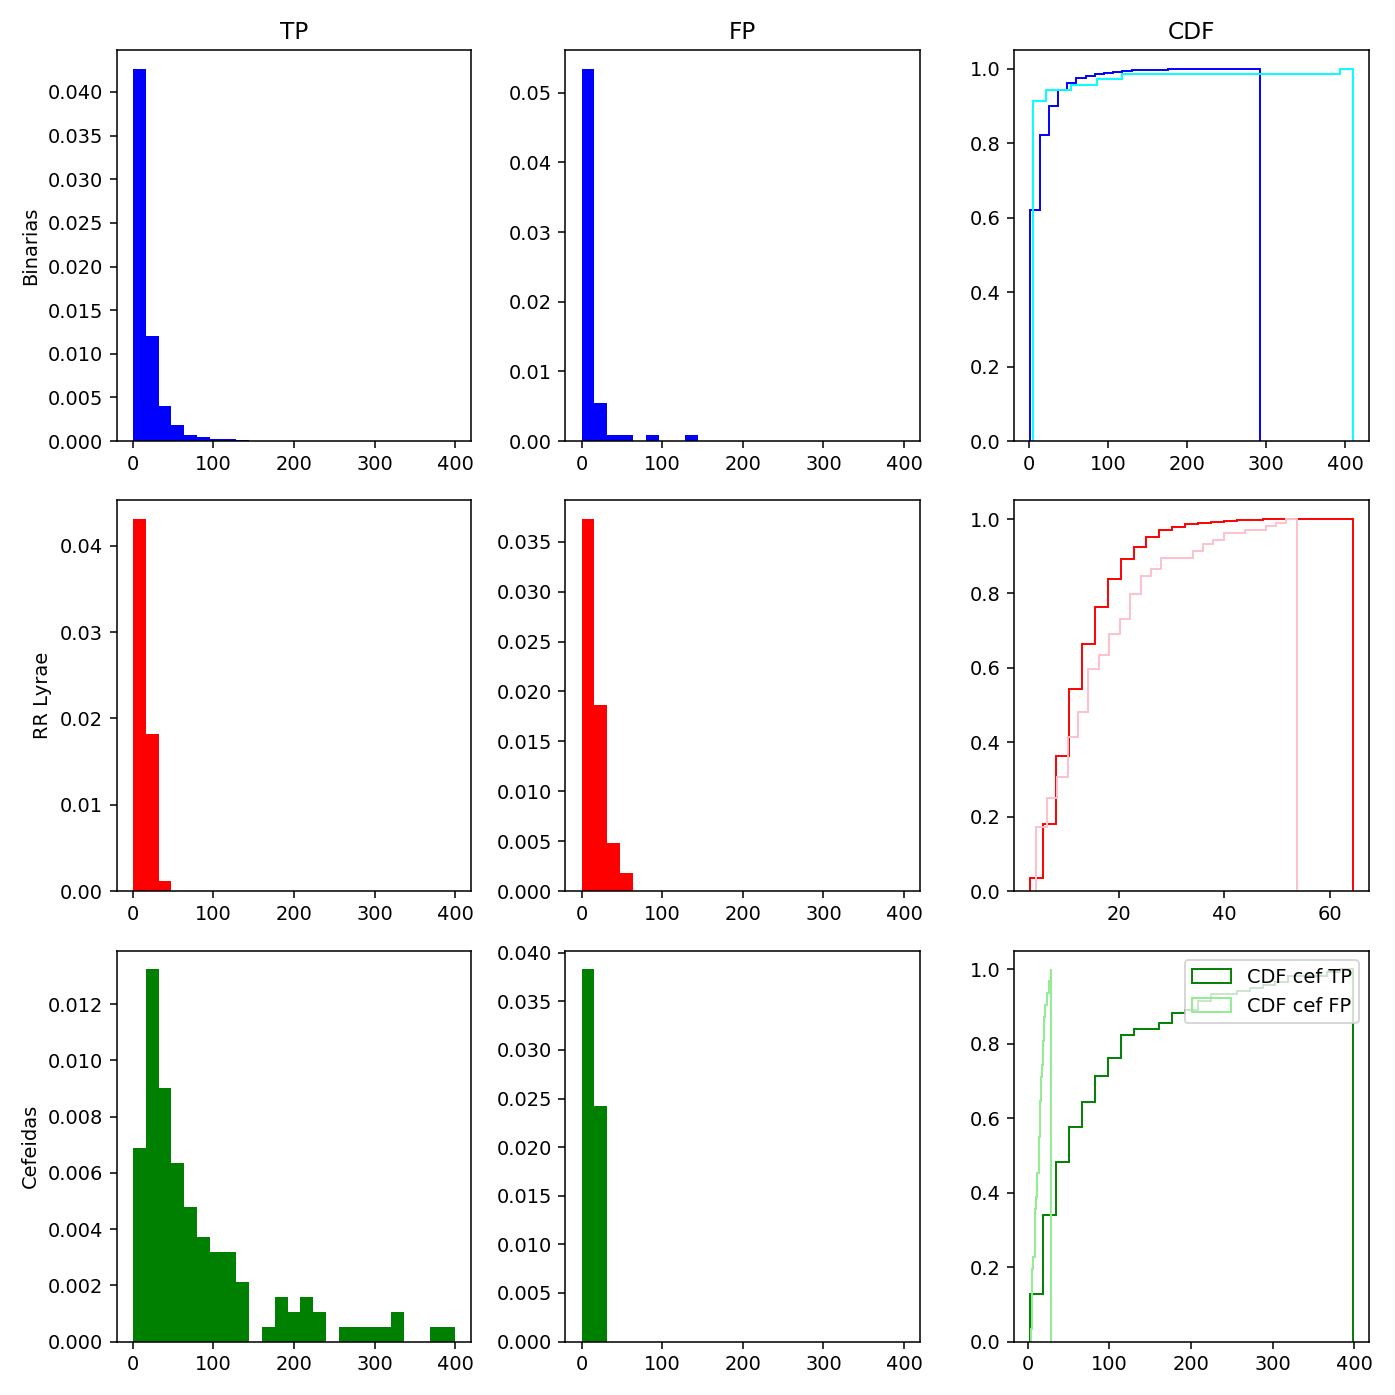

/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
/home/amorales/ana

In [76]:
fig,ax = plt.subplots(3,3,figsize=(10,10),tight_layout=True,sharey=False,sharex=False)
#fig.suptitle('SNR', fontsize=12)

bins=25
ran=(0,400)
ax[0][0].hist(SNR_bin[0],bins=bins,range=(0,400),density=True,color='blue')
ax[1][0].hist(SNR_rrl[1],bins=bins,range=(0,400),density=True,color='red')
ax[2][0].hist(SNR_cef[2],bins=bins,range=(0,400),density=True,color='green')
ax[0][1].hist(SNR_bin[1]+SNR_bin[2],bins=bins,range=(0,400),density=True,color='blue')
ax[1][1].hist(SNR_rrl[0]+SNR_rrl[2],bins=bins,range=(0,400),density=True,color='red')
ax[2][1].hist(SNR_cef[0]+SNR_cef[1],bins=bins,range=(0,400),density=True,color='green')
ax[0][2].hist(SNR_bin[0], bins, normed=1, histtype='step', cumulative=True, label='CDF bin TP',color='blue')
ax[1][2].hist(SNR_rrl[1], bins, normed=1, histtype='step', cumulative=True, label='CDF rrl TP',color='red')
ax[2][2].hist(SNR_cef[2], bins, normed=1, histtype='step', cumulative=True, label='CDF cef TP',color='green')
ax[0][2].hist(SNR_bin[1]+SNR_bin[2], bins, normed=1, histtype='step', cumulative=True, label='CDF bin FP',color='cyan')
ax[1][2].hist(SNR_rrl[0]+SNR_rrl[2], bins, normed=1, histtype='step', cumulative=True, label='CDF rrl FP',color='pink')
ax[2][2].hist(SNR_cef[0]+SNR_cef[1], bins, normed=1, histtype='step', cumulative=True, label='CDF cef FP',color='lightgreen')

#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')
ax[0][0].set_title('TP')
ax[0][1].set_title('FP')
ax[0][2].set_title('CDF')
#ax[0][2].set_title('Cefeidas')
plt.legend()

<IPython.core.display.Javascript object>


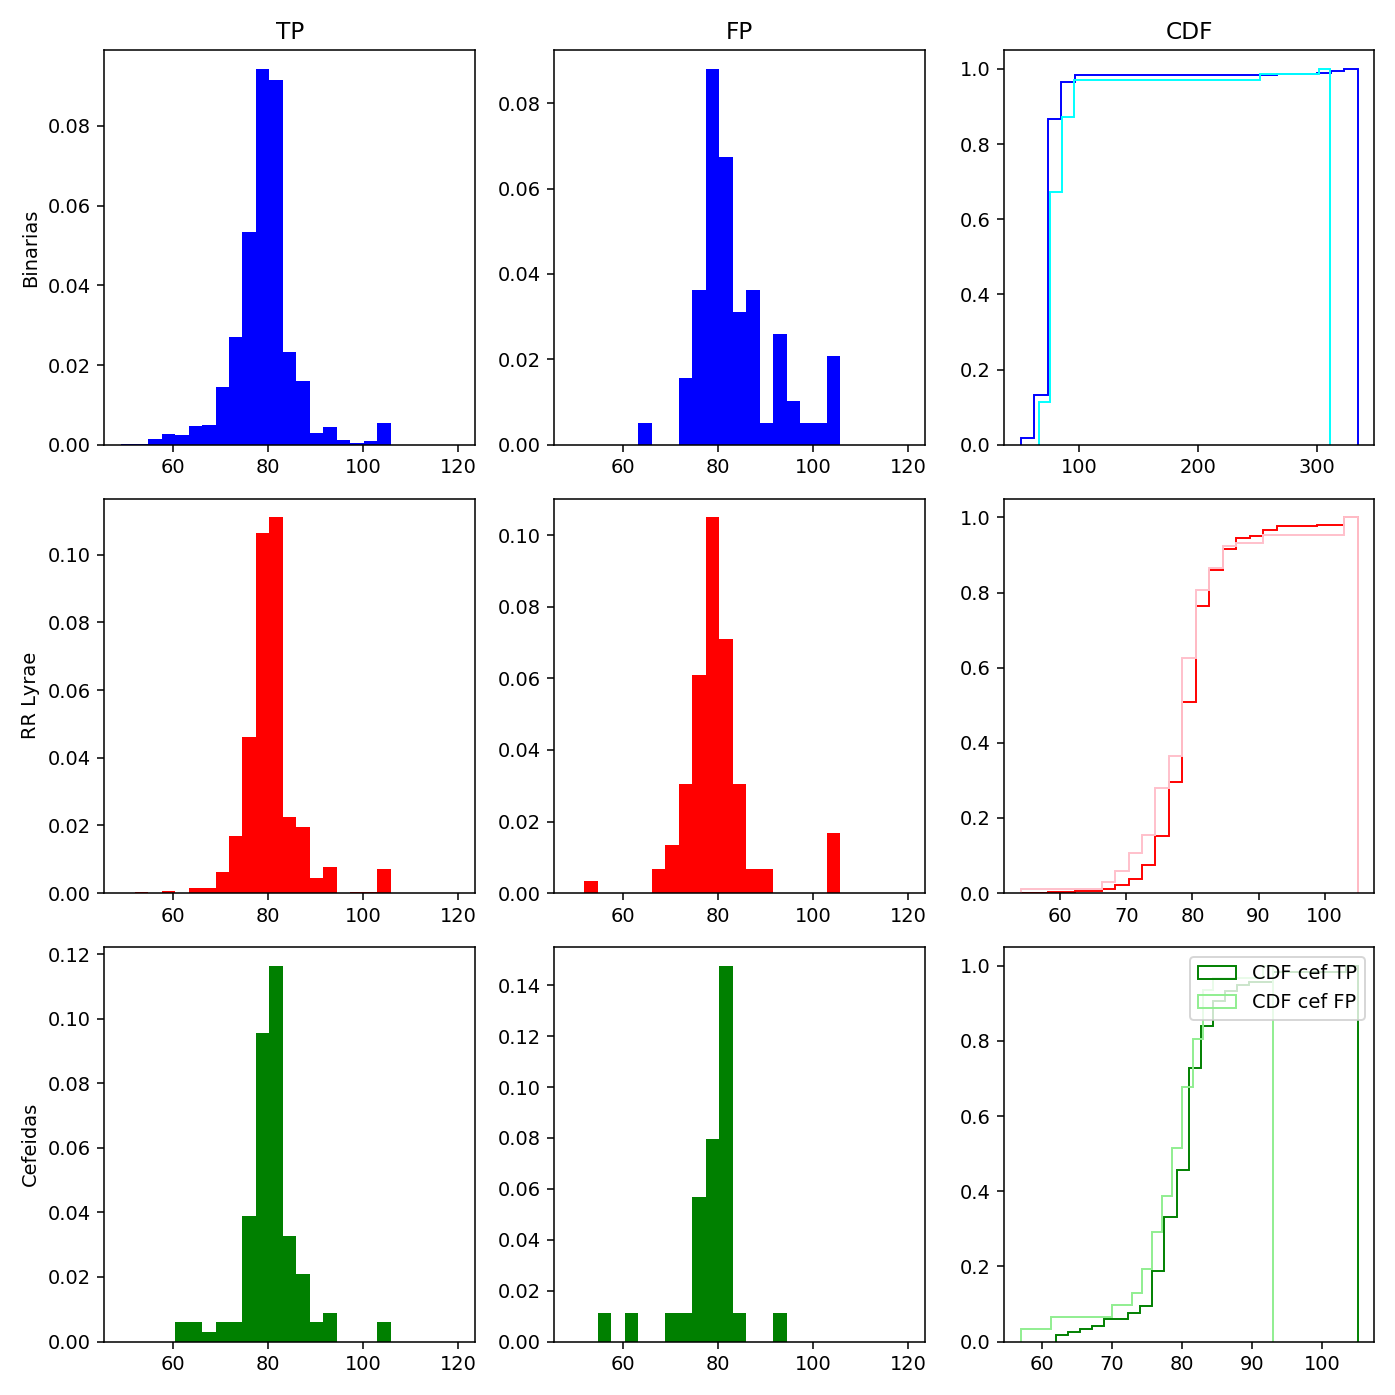

/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if sys.path[0] == '':
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  del sys.path[0]
/home/amorales/anaconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/

In [85]:
fig,ax = plt.subplots(3,3,figsize=(10,10),tight_layout=True,sharey=False,sharex=False)
#fig.suptitle('SNR', fontsize=12)


ax[0][0].hist(N_bin[0],bins=25,range=(49,120),density=True,color='blue')
ax[1][0].hist(N_rrl[1],bins=25,range=(49,120),density=True,color='red')
ax[2][0].hist(N_cef[2],bins=25,range=(49,120),density=True,color='green')
ax[0][1].hist(N_bin[1]+N_bin[2],bins=25,range=(49,120),density=True,color='blue')
ax[1][1].hist(N_rrl[0]+N_rrl[2],bins=25,range=(49,120),density=True,color='red')
ax[2][1].hist(N_cef[0]+N_cef[1],bins=25,range=(49,120),density=True,color='green')
ax[0][2].hist(N_bin[0], bins, normed=1, histtype='step', cumulative=True, label='CDF bin TP',color='blue')
ax[1][2].hist(N_rrl[1], bins, normed=1, histtype='step', cumulative=True, label='CDF rrl TP',color='red')
ax[2][2].hist(N_cef[2], bins, normed=1, histtype='step', cumulative=True, label='CDF cef TP',color='green')
ax[0][2].hist(N_bin[1]+N_bin[2], bins, normed=1, histtype='step', cumulative=True, label='CDF bin FP',color='cyan')
ax[1][2].hist(N_rrl[0]+N_rrl[2], bins, normed=1, histtype='step', cumulative=True, label='CDF rrl FP',color='pink')
ax[2][2].hist(N_cef[0]+N_cef[1], bins, normed=1, histtype='step', cumulative=True, label='CDF cef FP',color='lightgreen')


#ax[0].hist(entr_bin,bins=30,density=True)
ax[0][0].set_ylabel('Binarias')
#ax[1].hist(entr_rrl,bins=30,density=True)
ax[1][0].set_ylabel('RR Lyrae')
#ax[2].hist(entr_cef,bins=30,density=True)
ax[2][0].set_ylabel('Cefeidas')
ax[0][0].set_title('TP')
ax[0][1].set_title('FP')
ax[0][2].set_title('CDF')

#ax[0][2].set_title('Cefeidas')
plt.legend()

In [28]:
from scipy.signal import medfilt as mf

<IPython.core.display.Javascript object>


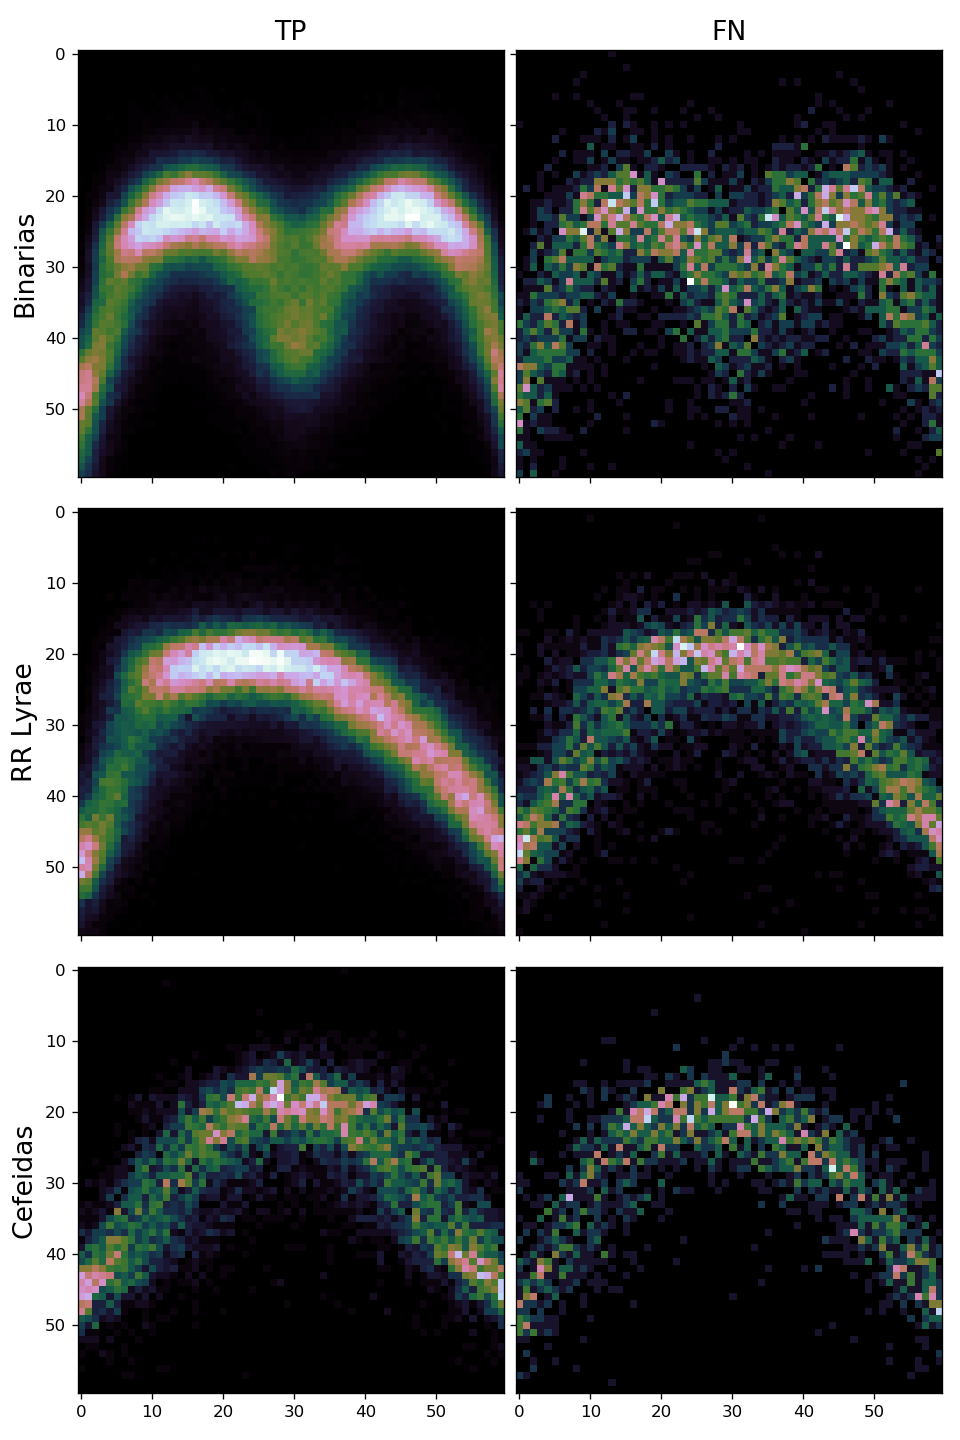

<IPython.core.display.Javascript object>


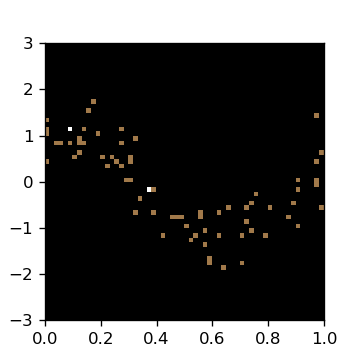

Text(0.5, 1.0, 'FN')

In [75]:
fig,ax = plt.subplots(3,2,figsize=(8,12),tight_layout=True,sharey=True,sharex=True)
fig2,ax2 = plt.subplots(1,figsize=(3,3))
res=60

cm=plt.get_cmap('cubehelix')
#fig.suptitle('Densidad por tipo de clasificación', fontsize=12)
LC = [bin_t,rrl_t,cef_t]
names = ['Binarias','RR Lyrae', 'Cefeidas']
#[ax_.cla() for ax_ in ax]
for i,stars in enumerate(LC):
    hTP=np.zeros(shape=(res,res))
    #hFP=np.zeros(shape=(res,res))
    hFN=np.zeros(shape=(res,res))
    for lc in stars:
        n=int(lc['data'][:, 4].sum().item())
        X=lc['data'][:n, 0].numpy()
        Y=lc['data'][:n, 1].numpy()
        yt=lc['label']
        yp=lc['pred']
        max_mag = np.argmax(mf(Y,5))

        X_roll = np.roll(X,-max_mag)
        Y_roll = np.roll(Y,-max_mag)

        h, xedge, yedge, _ = ax2.hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
        #print(hall)
        if yt==yp:
            hTP += h
        else:
            hFN += h
        #print(hFN.shape)
    ax[i][0].imshow(hTP.T,cmap=cm)
    #ax[i][0].axis('off')
    ax[i][0].set_ylabel(names[i],fontsize=16)
    ax[i][1].imshow(hFN.T,cmap=cm)
    #ax[i][1].axis('off')
    #ax[i][2].set_visible(False)
    
ax[0][0].set_title("TP",fontsize=16)
ax[0][1].set_title("FN",fontsize=16)
#ax[1].hist2d(X,Y_roll,bins=20)
#ax[0].invert_yaxis()
#ax[1].invert_yaxis()
#ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, rrl_t[idx]['label'],rrl_t[idx]['name']), fontsize=10)
#interact(update, idx=SelectionSlider(options=range(len(rrl_t))))

<IPython.core.display.Javascript object>


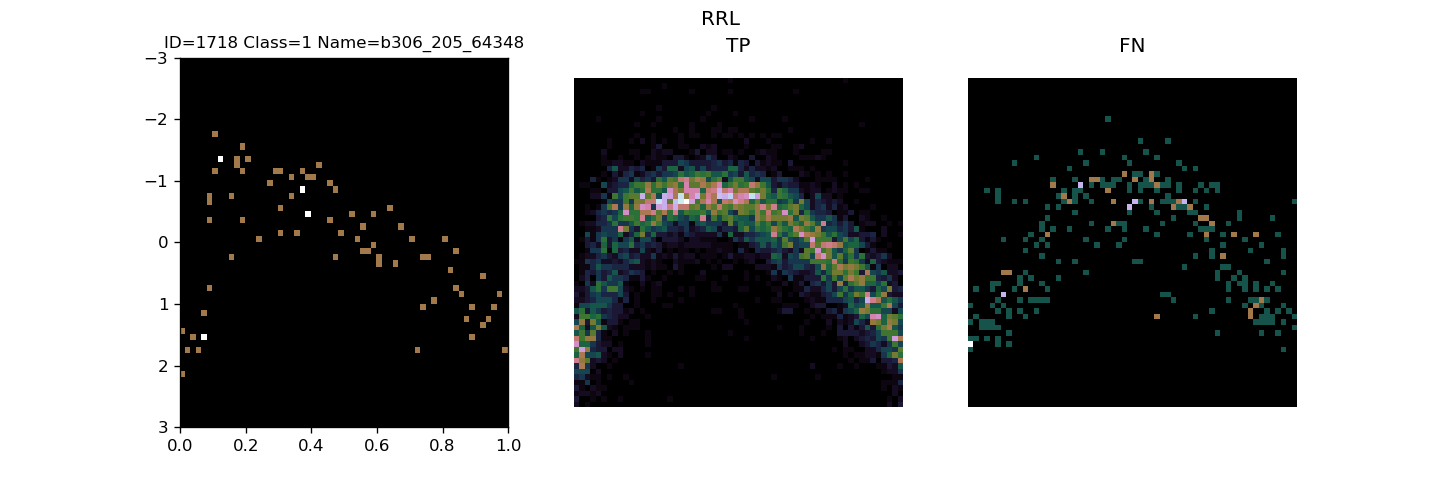

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [155]:
fig,ax = plt.subplots(1,3,figsize=(12,4),tight_layout=False,sharey=False)
res=60
hTP=np.zeros(shape=(res,res))
#hFP=np.zeros(shape=(res,res))
hFN=np.zeros(shape=(res,res))
cm=plt.get_cmap('cubehelix')
fig.suptitle('RRL', fontsize=12)
def update(idx):
    global hTP,hFN,res,cm
    #[ax_.cla() for ax_ in ax]
    
    n=int(rrl_t[idx]['data'][:, 4].sum().item())
    X=rrl_t[idx]['data'][:n, 0].numpy()
    Y=rrl_t[idx]['data'][:n, 1].numpy()
    yt=rrl_t[idx]['label']
    yp=rrl_t[idx]['pred']
    max_mag = np.argmax(mf(Y,5))
    
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
  
    h, xedge, yedge, _ = ax[0].hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
    #print(hall)
    if yt==yp:
        hTP += h
    else:
        hFN += h
    ax[1].matshow(hTP.T,cmap=cm)
    ax[1].axis('off')
    ax[1].set_title("TP")
    ax[2].matshow(hFN.T,cmap=cm)
    ax[2].axis('off')
    ax[2].set_title("FN")
    #ax[1].hist2d(X,Y_roll,bins=20)
    ax[0].invert_yaxis()
    #ax[1].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, rrl_t[idx]['label'],rrl_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(rrl_t))))

<IPython.core.display.Javascript object>


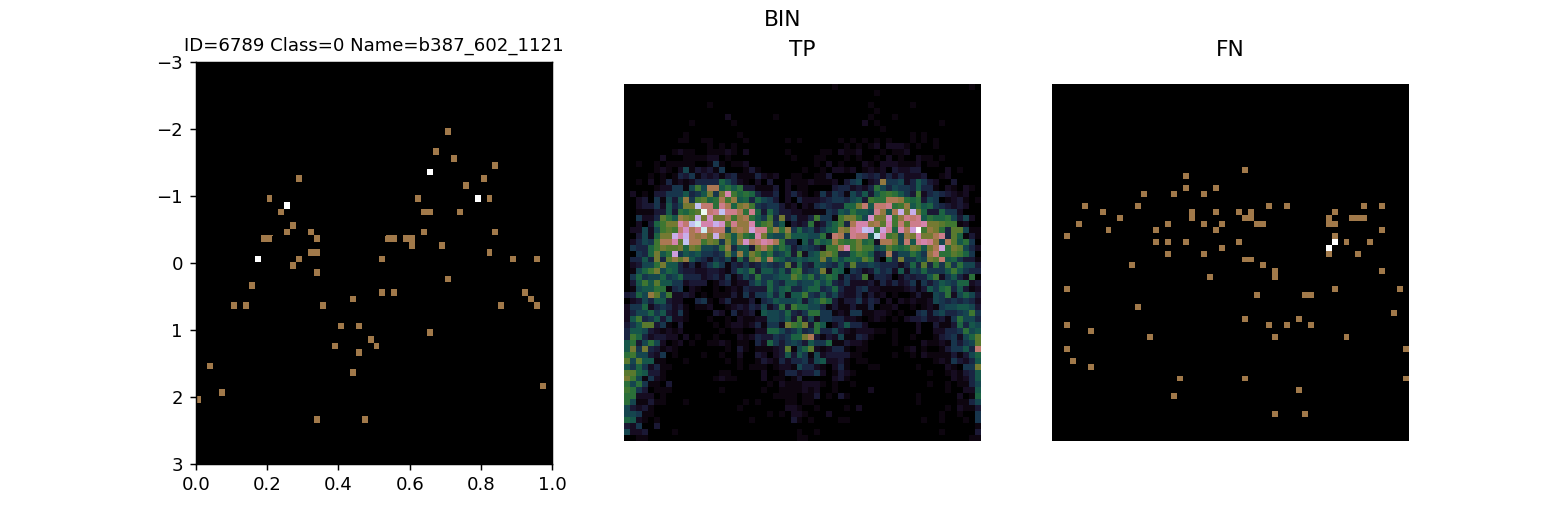

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [130]:
fig,ax = plt.subplots(1,3,figsize=(12,4),tight_layout=False,sharey=False)
res=60
hTP=np.zeros(shape=(res,res))
#hFP=np.zeros(shape=(res,res))
hFN=np.zeros(shape=(res,res))
cm=plt.get_cmap('cubehelix')
fig.suptitle('BIN', fontsize=12)
def update(idx):
    global hTP,hFN,res,cm
    #[ax_.cla() for ax_ in ax]
    
    n=int(bin_t[idx]['data'][:, 4].sum().item())
    X=bin_t[idx]['data'][:n, 0].numpy()
    Y=bin_t[idx]['data'][:n, 1].numpy()
    yt=bin_t[idx]['label']
    yp=bin_t[idx]['pred']
    max_mag = np.argmax(mf(Y,5))
    
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
  
    h, xedge, yedge, _ = ax[0].hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
    #print(hall)
    if yt==yp:
        hTP += h
    else:
        hFN += h
    ax[1].matshow(hTP.T,cmap=cm)
    ax[1].axis('off')
    ax[1].set_title("TP")
    ax[2].matshow(hFN.T,cmap=cm)
    ax[2].axis('off')
    ax[2].set_title("FN")
    #ax[1].hist2d(X,Y_roll,bins=20)
    ax[0].invert_yaxis()
    #ax[1].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, bin_t[idx]['label'],bin_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(bin_t))))

<IPython.core.display.Javascript object>


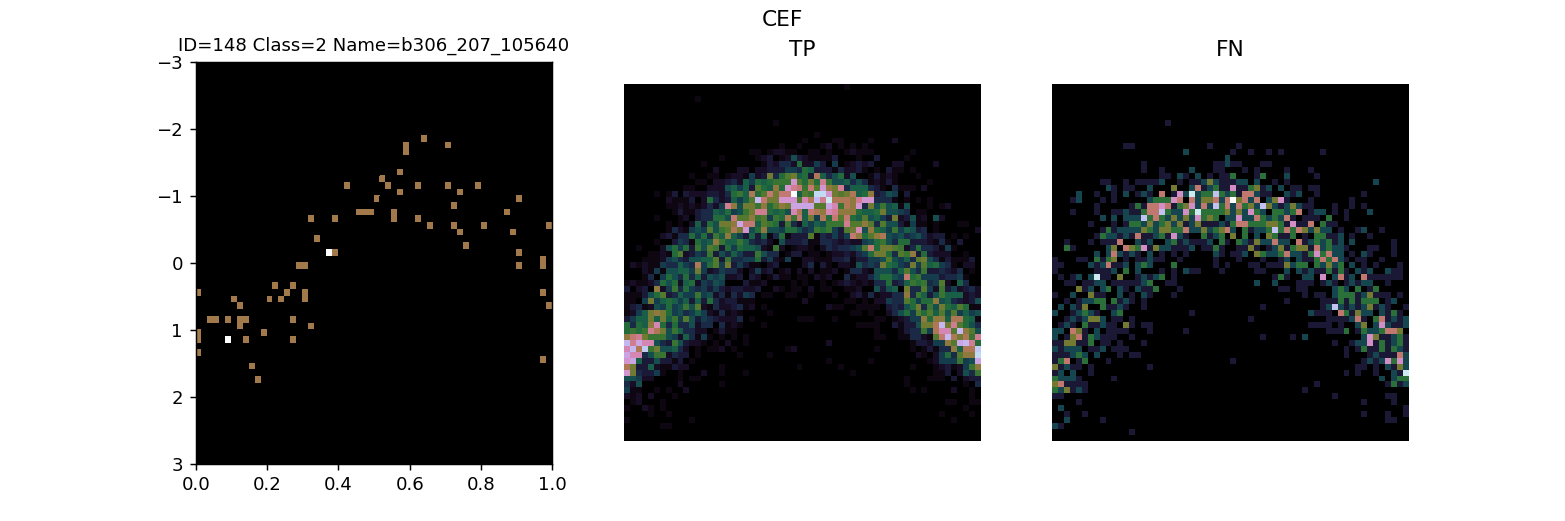

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [131]:
fig,ax = plt.subplots(1,3,figsize=(12,4),tight_layout=False,sharey=False)
res=60
hTP=np.zeros(shape=(res,res))
#hFP=np.zeros(shape=(res,res))
hFN=np.zeros(shape=(res,res))
cm=plt.get_cmap('cubehelix')
fig.suptitle('CEF', fontsize=12)
def update(idx):
    global hTP,hFN,res,cm
    #[ax_.cla() for ax_ in ax]
    
    n=int(cef_t[idx]['data'][:, 4].sum().item())
    X=cef_t[idx]['data'][:n, 0].numpy()
    Y=cef_t[idx]['data'][:n, 1].numpy()
    yt=cef_t[idx]['label']
    yp=cef_t[idx]['pred']
    max_mag = np.argmax(mf(Y,5))
    
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
  
    h, xedge, yedge, _ = ax[0].hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
    #print(hall)
    if yt==yp:
        hTP += h
    else:
        hFN += h
    ax[1].matshow(hTP.T,cmap=cm)
    ax[1].axis('off')
    ax[1].set_title("TP")
    ax[2].matshow(hFN.T,cmap=cm)
    ax[2].axis('off')
    ax[2].set_title("FN")
    #ax[1].hist2d(X,Y_roll,bins=20)
    ax[0].invert_yaxis()
    #ax[1].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, cef_t[idx]['label'],cef_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(cef_t))))

<IPython.core.display.Javascript object>


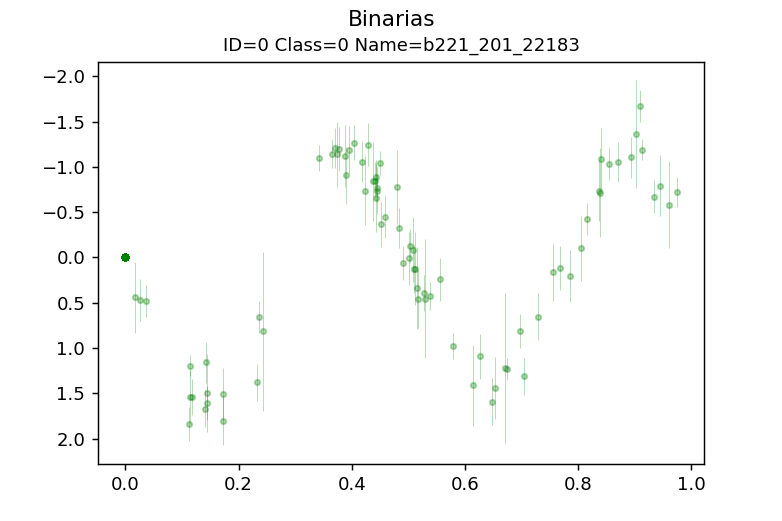

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [120]:
fig,ax = plt.subplots(1,figsize=(6,4),tight_layout=False)

fig.suptitle('Binarias', fontsize=12)
def update(idx):
    ax.cla()  
    ax.errorbar(binarias[idx]['data'][:, 0], binarias[idx]['data'][:, 1], binarias[idx]['data'][:, 2], fmt='.',color='g',elinewidth=0.5,alpha=0.3)
    ax.invert_yaxis()
    ax.set_title("ID=%d Class=%d Name=%s" %(idx, binarias[idx]['label'],binarias[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(binarias))))

<IPython.core.display.Javascript object>


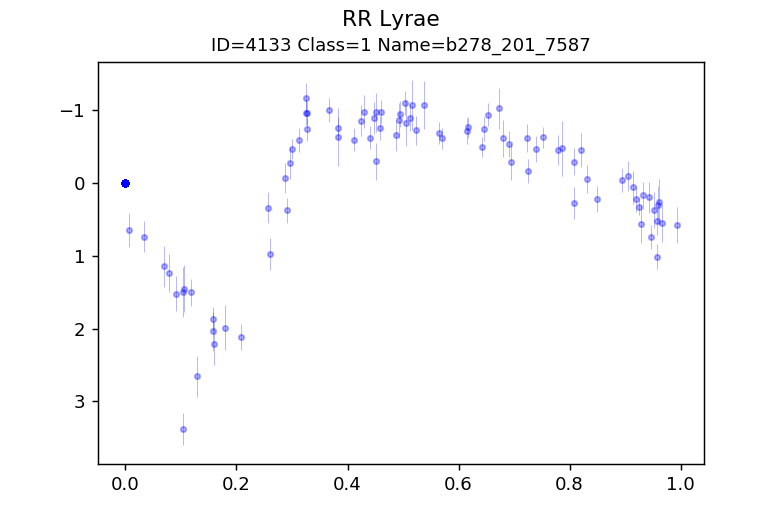

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [121]:
fig,ax = plt.subplots(1,figsize=(6,4),tight_layout=False)

fig.suptitle('RR Lyrae', fontsize=12)
def update(idx):
    ax.cla()  
    ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax.invert_yaxis()
    ax.set_title("ID=%d Class=%d Name=%s" %(idx, rrlyrae[idx]['label'],rrlyrae[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(rrlyrae))))

<IPython.core.display.Javascript object>


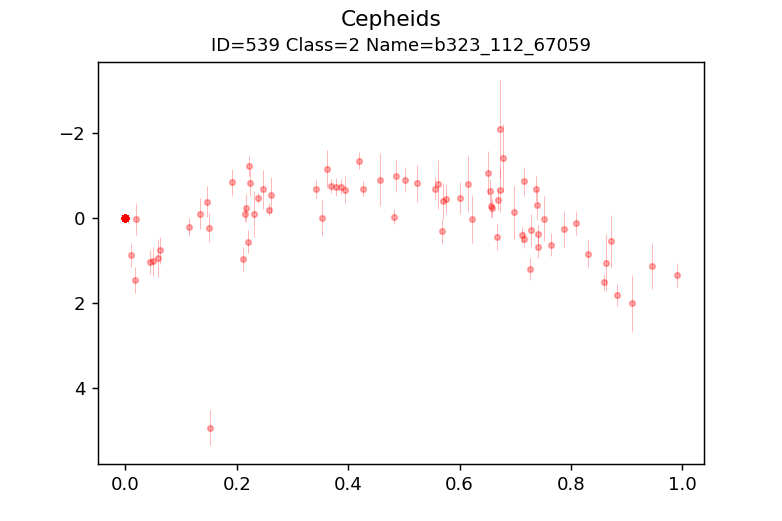

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [122]:
fig,ax = plt.subplots(1,figsize=(6,4),tight_layout=False)

fig.suptitle('Cepheids', fontsize=12)
def update(idx):
    ax.cla()  
    ax.errorbar(cefeidas[idx]['data'][:, 0], cefeidas[idx]['data'][:, 1], cefeidas[idx]['data'][:, 2], fmt='.',color='r',elinewidth=0.5,alpha=0.3)
    ax.invert_yaxis()
    ax.set_title("ID=%d Class=%d Name=%s" %(idx, cefeidas[idx]['label'],cefeidas[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(cefeidas))))

In [132]:
int(rrlyrae[500]['data'][:, 4].sum().item())

75

<IPython.core.display.Javascript object>


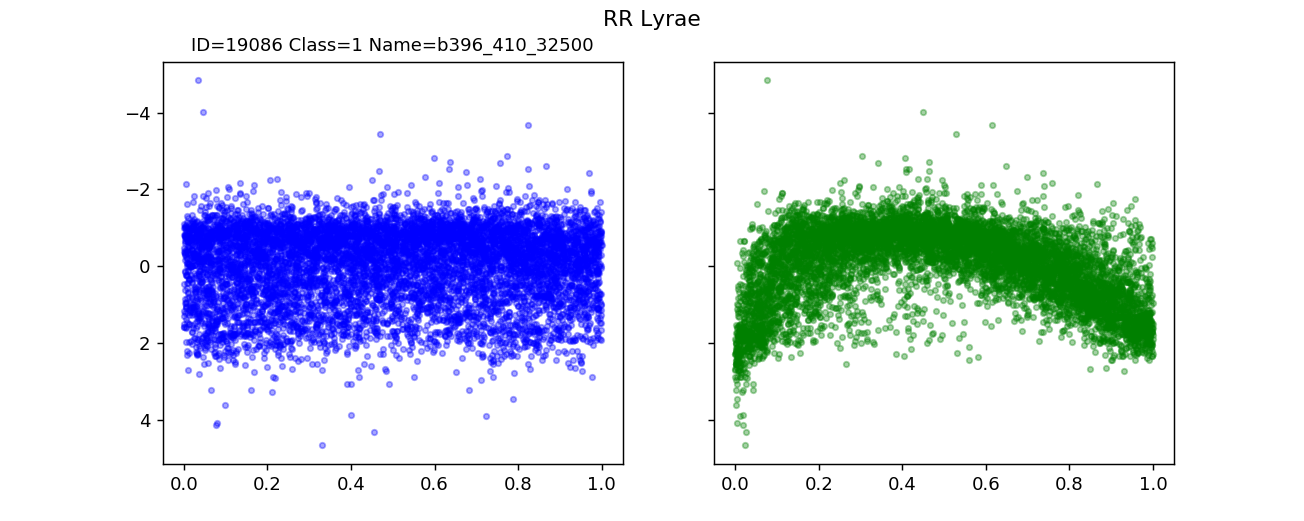

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [150]:
fig,ax = plt.subplots(1,2,figsize=(10,4),tight_layout=False,sharey=True)

fig.suptitle('RR Lyrae', fontsize=12)
def update(idx):
    n=int(rrlyrae[idx]['data'][:, 4].sum().item())
    
    X=rrlyrae[idx]['data'][:n, 0].numpy()
    Y=rrlyrae[idx]['data'][:n, 1].numpy()
    max_mag = np.argmax(Y)
    #[ax_.cla() for ax_ in ax]
    ax[0].plot(X,Y,'b.',alpha=0.35)
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
    ax[1].plot(X,Y_roll,'g.',alpha=0.35)
    #ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax[0].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, rrlyrae[idx]['label'],rrlyrae[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(rrlyrae))))

<IPython.core.display.Javascript object>


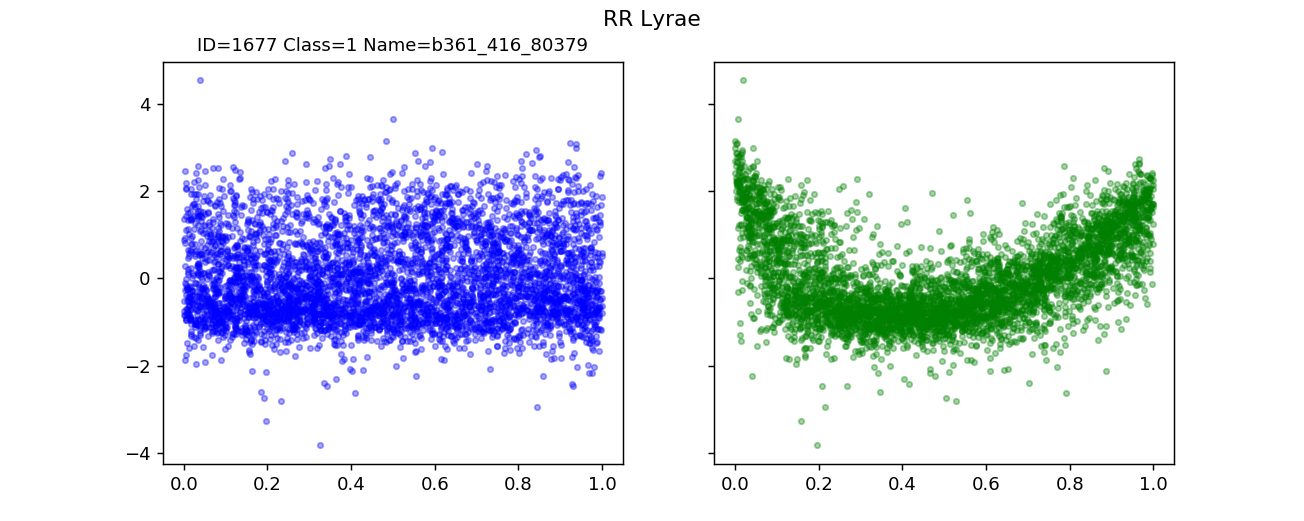

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [152]:
fig,ax = plt.subplots(1,2,figsize=(10,4),tight_layout=False,sharey=True)

fig.suptitle('RR Lyrae', fontsize=12)
def update(idx):
    n=int(rrl_t[idx]['data'][:, 4].sum().item())
    
    X=rrl_t[idx]['data'][:n, 0].numpy()
    Y=rrl_t[idx]['data'][:n, 1].numpy()
    max_mag = np.argmax(Y)
    #[ax_.cla() for ax_ in ax]
    ax[0].plot(X,Y,'b.',alpha=0.35)
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
    ax[1].plot(X,Y_roll,'g.',alpha=0.35)
    #ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax[0].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, rrl_t[idx]['label'],rrl_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(rrl_t))))

<IPython.core.display.Javascript object>


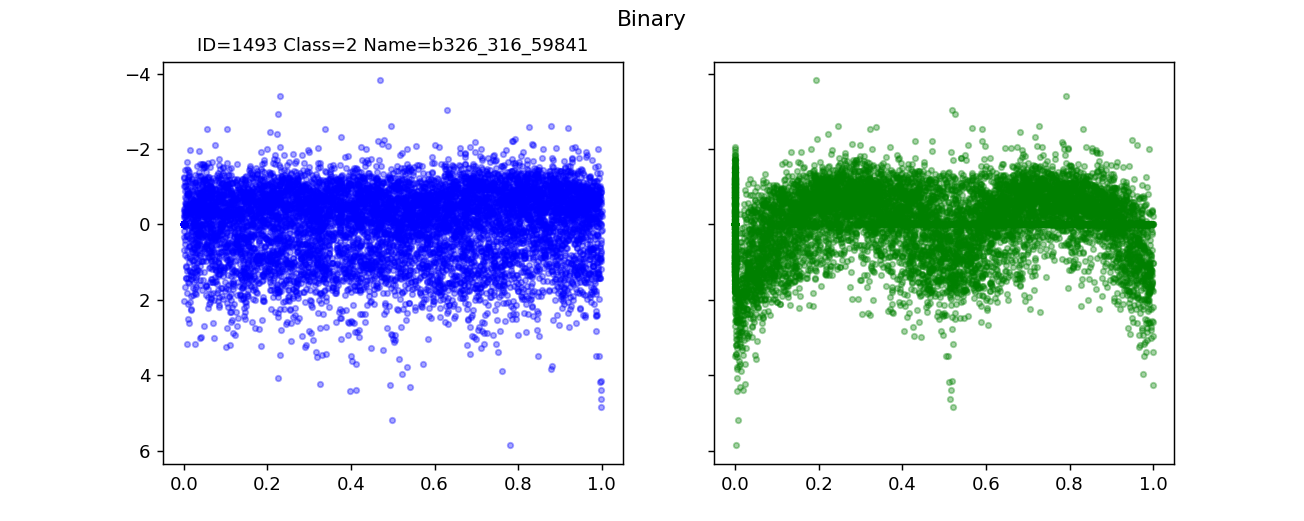

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [134]:
fig,ax = plt.subplots(1,2,figsize=(10,4),tight_layout=False,sharey=True)

fig.suptitle('Binary', fontsize=12)
def update(idx):
    n=int(binarias[idx]['data'][:, 4].sum().item())
    X=binarias[idx]['data'][:n, 0].numpy()
    Y=binarias[idx]['data'][:n, 1].numpy()
    max_mag = np.argmax(Y)
    #[ax_.cla() for ax_ in ax]
    ax[0].plot(X,Y,'b.',alpha=0.35)
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
    ax[1].plot(X,Y_roll,'g.',alpha=0.35)
    #ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax[0].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, binarias[idx]['label'],binarias[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(binarias))))

<IPython.core.display.Javascript object>


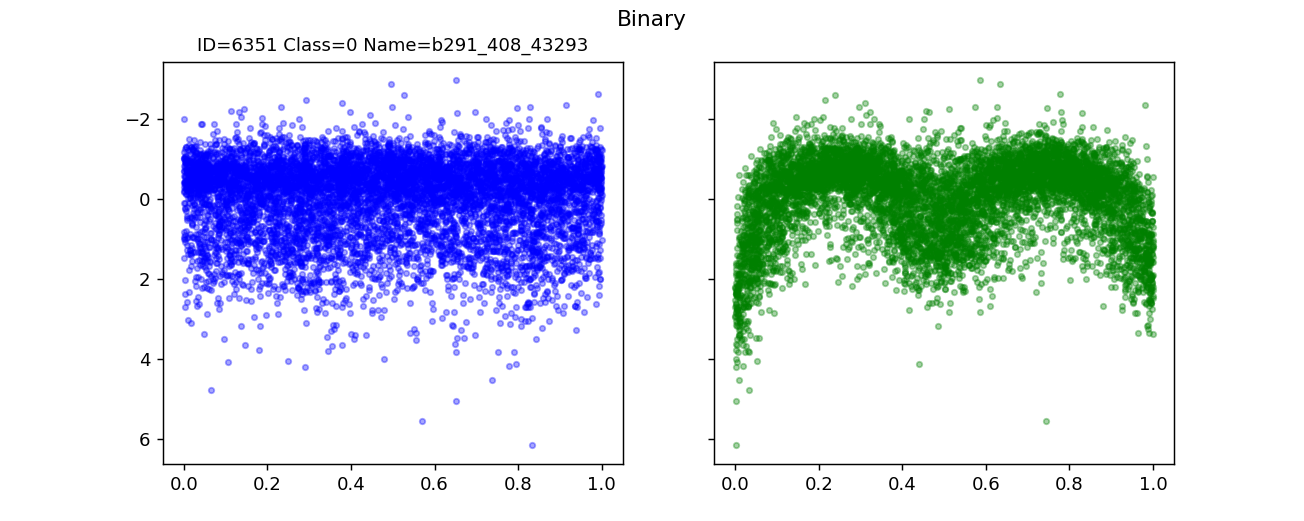

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [153]:
fig,ax = plt.subplots(1,2,figsize=(10,4),tight_layout=False,sharey=True)

fig.suptitle('Binary', fontsize=12)
def update(idx):
    n=int(bin_t[idx]['data'][:, 4].sum().item())
    X=bin_t[idx]['data'][:n, 0].numpy()
    Y=bin_t[idx]['data'][:n, 1].numpy()
    max_mag = np.argmax(Y)
    #[ax_.cla() for ax_ in ax]
    ax[0].plot(X,Y,'b.',alpha=0.35)
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
    ax[1].plot(X,Y_roll,'g.',alpha=0.35)
    #ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax[0].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, bin_t[idx]['label'],bin_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(bin_t))))

<IPython.core.display.Javascript object>


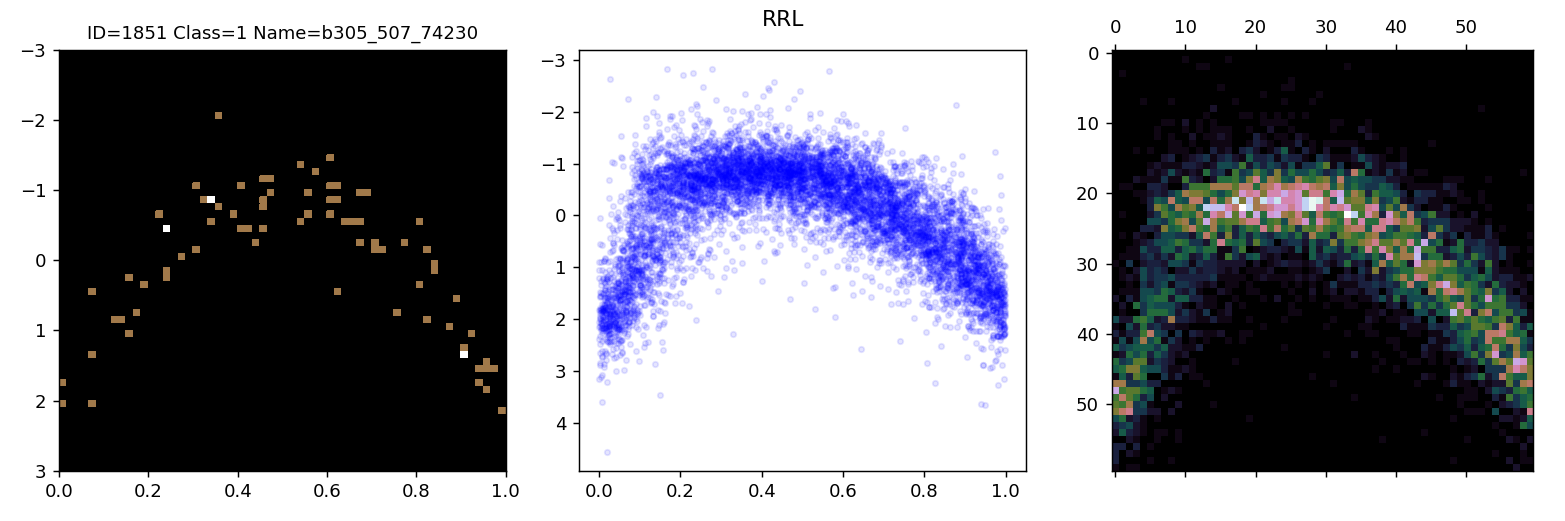

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [107]:
fig,ax = plt.subplots(1,3,figsize=(12,4),tight_layout=True,sharey=False)
res=60
hall=np.zeros(shape=(res,res))
cm=plt.get_cmap('cubehelix')
fig.suptitle('RRL', fontsize=12)
def update(idx):
    global hall,res,cm
    
    n=int(rrl_t[idx]['data'][:, 4].sum().item())
    X=rrl_t[idx]['data'][:n, 0].numpy()
    Y=rrl_t[idx]['data'][:n, 1].numpy()
    max_mag = np.argmax(mf(Y,5))
    #[ax_.cla() for ax_ in ax]
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag)
    ax[1].plot(X,Y_roll,'b.',alpha=0.1)
    #ax[1].plot(X,Y_roll,'g.',alpha=0.1)
    h, xedge, yedge, _ = ax[0].hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
    #print(hall)
    hall += h
    ax[2].matshow(hall.T,cmap=cm)
    #ax[1].hist2d(X,Y_roll,bins=20)
    #ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, rrl_t[idx]['label'],rrl_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(rrl_t))))

<IPython.core.display.Javascript object>


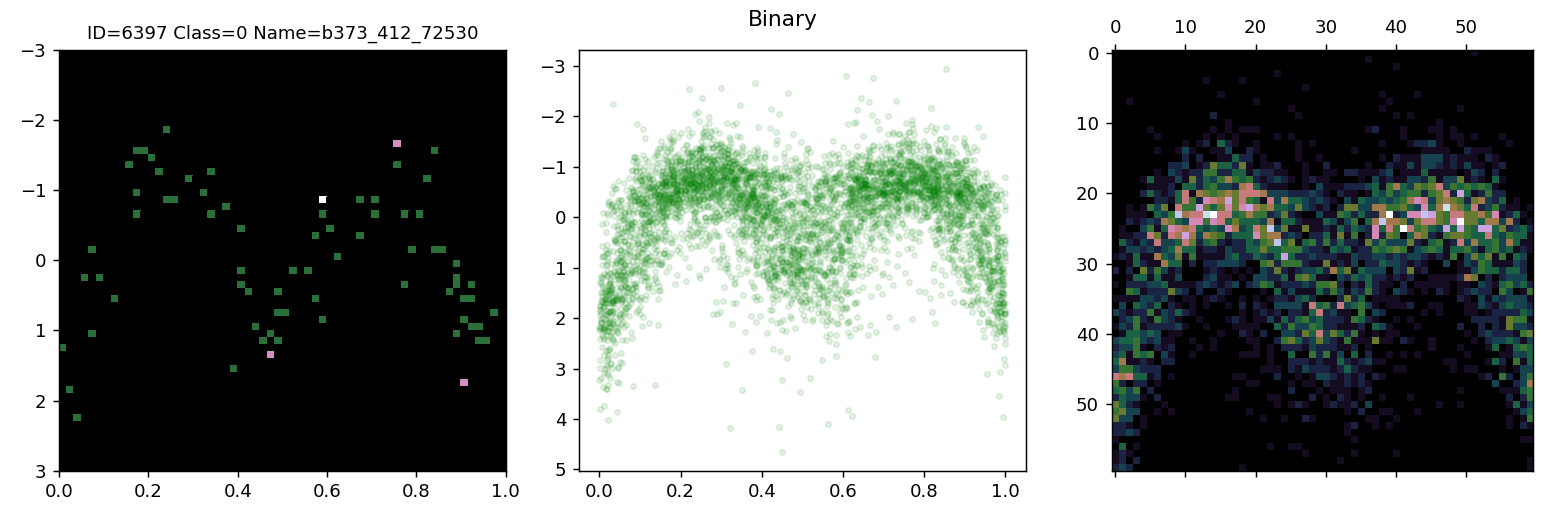

interactive(children=(SelectionSlider(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…

<function __main__.update(idx)>

In [216]:
fig,ax = plt.subplots(1,3,figsize=(12,4),tight_layout=True,sharey=False)
res=60
hall=np.zeros(shape=(res,res))
fig.suptitle('Binary', fontsize=12)
def update(idx):
    global hall,res
    cm=plt.get_cmap('cubehelix')
    n=int(bin_t[idx]['data'][:, 4].sum().item())
    X=bin_t[idx]['data'][:n, 0].numpy()
    Y=bin_t[idx]['data'][:n, 1].numpy()
    max_mag = np.argmax(mf(Y,5))
    #[ax_.cla() for ax_ in ax]
    #ax[0].plot(X,Y,'b.',alpha=0.1)
    X_roll = np.roll(X,-max_mag)
    Y_roll = np.roll(Y,-max_mag) 
    ax[1].plot(X,Y_roll,'g.',alpha=0.1)
    h, xedge, yedge, _ = ax[0].hist2d(X,Y_roll,bins=res, range=[[0,1],[-3,3]],cmap=cm)
    #print(hall)
    hall += h
    ax[2].matshow(hall.T,cmap=cm)
    #ax[1].hist2d(X,Y_roll,bins=20)
    #ax.errorbar(rrlyrae[idx]['data'][:, 0], rrlyrae[idx]['data'][:, 1], rrlyrae[idx]['data'][:, 2], fmt='.',color='b',elinewidth=0.5,alpha=0.3)
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[0].set_title("ID=%d Class=%d Name=%s" %(idx, bin_t[idx]['label'],bin_t[idx]['name']), fontsize=10)
interact(update, idx=SelectionSlider(options=range(len(bin_t))))